In [1]:
import os
import path 
import numpy as np
import pandas as pd
import re
import torch
import collections
import random
import gffpandas.gffpandas as gffpd
import random
from Bio.Seq import Seq

import scipy
import scipy.stats
import matplotlib.pyplot as plt
directory = os.getcwd()
folders = os.listdir(directory)

In [2]:
genomes = [name for name in os.listdir("/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/")]
genomes.remove('.DS_Store')
sorted_genomes = sorted(genomes)


In [3]:
random.seed(5)
torch.manual_seed(5)
train_x = np.array([])
train_y = np.array([])
test_x = np.array([])
test_y = np.array([])

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def read_fasta(dir_name, genome_name, file_name):
    #'sampled_genomes_resampled/'
    f=open(str(dir_name) + '/' + str(genome_name) + '/' + file_name,'r')
    lines=f.readlines()

    hre=re.compile('>(\S+)')
    lre=re.compile('^(\S+)$')

    gene={}

    for line in lines:
            outh = hre.search(line)
            if outh:
                    id=outh.group(1)
            else:
                    outl=lre.search(line)
                    if(id in gene.keys()):
                            gene[id] += outl.group(1)
                    else:
                            gene[id]  =outl.group(1)
    return list(gene.values())

def create_csv(dir_name, genome, coding_seqs, sampled_noncoding_seqs):
    num_coding_seqs = len(coding_seqs)
    num_noncoding_seqs = len(sampled_noncoding_seqs)
    coding_indices = np.arange(0, num_coding_seqs, 1)
    coding_groundtruth = np.arange(0, num_coding_seqs, 1)
    coding_train = ['train'] * num_coding_seqs
    noncoding_indices = np.arange(0, num_noncoding_seqs, 1)
    noncoding_test = ['test'] * num_noncoding_seqs
    noncoding_groundtruth = np.arange(0, num_noncoding_seqs, 1)
    
    data = {'sequence': coding_seqs, 'target': coding_groundtruth, 'set': coding_train, 'validation': [np.nan] * num_coding_seqs}
    coding_df = pd.DataFrame(data, index=coding_indices)
    coding_df.to_csv(dir_name + '/' + genome + '/debug_coding_train.csv')
    
    data = {'sequence': sampled_noncoding_seqs, 'target': noncoding_groundtruth, 'set': noncoding_test, 'validation': [np.nan] * num_noncoding_seqs}
    noncoding_df = pd.DataFrame(data, index=noncoding_indices)
    noncoding_df.to_csv(dir_name + '/' + genome + '/debug_noncoding_test.csv')
    
def find_first_index(lst, target):
    """
    Finds the index of the first matching element in the given list.
    If no match is found, returns -1.
    """
    for i, item in enumerate(lst):
        if item == target:
            return i
    return -1

    
def create_dict(lst):
    result = {element: [] for element in lst}
    return result

def filter_duplicate_subdirectories(directories):
    """
    Returns a dictionary where the keys are directory names and the values are lists of subdirectories,
    filtered to exclude duplicates except for the first encounter of each subdirectory name
    in the order of directories sorted in lexicographic order.
    """
    filtered_directory_indices = create_dict(directories.keys())
    filtered_directory_genes = create_dict(directories.keys())
    subdirectory_set = set()
    for directory_name in sorted(directories.keys()):
        for i in range(len(directories[directory_name])):
            if not directories[directory_name][i] in subdirectory_set:
                filtered_directory_indices[directory_name].append(i)
                filtered_directory_genes[directory_name].append(directories[directory_name][i])
                subdirectory_set.add(directories[directory_name][i])
            else:
                continue
    return filtered_directory_genes

    

# loading sampled data

In [6]:
random.seed(5)
torch.manual_seed(5)
coding_genes = []
noncoding_genes = []
positive_genomes = {}
negative_genomes = {}
for genome in genomes:
    # adding a length constraint
    length_upper_limit = 60
    length_lower_limit = 0
    positive_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/coding_train.csv')['sequence'])
    negative_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/noncoding_test.csv')['sequence'])
    positive_testing_sequences = [positive_testing_sequence for positive_testing_sequence in positive_testing_sequences if len(positive_testing_sequence) < 60]
    negative_testing_sequences = [negative_testing_sequence for negative_testing_sequence in negative_testing_sequences if len(negative_testing_sequence) < 60]
    coding_genes.extend(positive_testing_sequences)
    noncoding_genes.extend(negative_testing_sequences)
    
    positive_genomes[genome] = positive_testing_sequences
    negative_genomes[genome] = negative_testing_sequences
    

In [7]:
print('In total, there are ' + str(len(coding_genes)) + ' coding regions, out of which ' + str(len(set(coding_genes))) + ' are unique.')
print('In total, there are ' + str(len(noncoding_genes)) + ' noncoding regions, out of which ' + str(len(set(noncoding_genes))) + ' are unique.')


In total, there are 145232 coding regions, out of which 128615 are unique.
In total, there are 145231 noncoding regions, out of which 143362 are unique.


In [8]:
import collections
result = collections.Counter(coding_genes) & collections.Counter(noncoding_genes)
intersected_list = list(result.elements())
print(len(intersected_list))
print(len(set(intersected_list)))

39
38


In [9]:
#removing these from all datasets
unique_intersected_list = set(intersected_list)
for genome in genomes:
    for gene in positive_genomes[genome]:
        if gene in unique_intersected_list:
            positive_genomes[genome].remove(gene)
    for gene in negative_genomes[genome]:
        if gene in unique_intersected_list:
            negative_genomes[genome].remove(gene)

## filtering out sequences which are longer or equal to 60 AAs

In [10]:
for genome in genomes:
    for gene in positive_genomes[genome]:
        if len(gene) >= 60:
            positive_genomes[genome].remove(gene)
    for gene in negative_genomes[genome]:
        if len(gene) >= 60:
            negative_genomes[genome].remove(gene)

### filtering duplicates in lexicographical order

In [204]:
def filter_duplicate_subdirectories(directories):
    """
    Returns a dictionary where the keys are directory names and the values are lists of subdirectories,
    filtered to exclude duplicates except for the first encounter of each subdirectory name
    in the order of directories sorted in lexicographic order.
    """
    filtered_directory_indices = create_dict(directories.keys())
    filtered_directory_genes = create_dict(directories.keys())
    subdirectory_set = set()
    for directory_name in sorted(directories.keys()):
        for i in range(len(directories[directory_name])):
            if not directories[directory_name][i] in subdirectory_set:
                filtered_directory_indices[directory_name].append(i)
                filtered_directory_genes[directory_name].append(directories[directory_name][i])
                subdirectory_set.add(directories[directory_name][i])
            else:
                continue
    return filtered_directory_genes

In [12]:
#running filtering on all genomes
positive_filtered_genes = filter_duplicate_subdirectories(positive_genomes)
negative_filtered_genes = filter_duplicate_subdirectories(negative_genomes)

In [13]:
#sanity check that there are no duplicates and no shared elements in coding regions and noncoding regions
print('There are ' + str(len(collections.Counter(flatten(positive_filtered_genes.values())) & collections.Counter(flatten(negative_filtered_genes.values())))) + ' intersected sequences')
assert(len(flatten(positive_filtered_genes.values())) == len(set(flatten(positive_filtered_genes.values()))))
assert(len(flatten(negative_filtered_genes.values())) == len(set(flatten(negative_filtered_genes.values()))))


There are 0 intersected sequences


In [14]:
#data after filtering
print('There are, in total, ' + str(len(flatten(positive_filtered_genes.values()))) + ' coding regions')
print('There are, in total, ' + str(len(flatten(negative_filtered_genes.values()))) + ' noncoding regions')


There are, in total, 128578 coding regions
There are, in total, 143325 noncoding regions


In [16]:
#get all the indices:
positive_filtered_genes_indices = {}
negative_filtered_genes_indices = {}

def indices_of_elements(list1, list2):
    indices = []
    for element in list1:
        try:
            index = list2.index(element)
            indices.append(index)
        except ValueError:
            print('sequence not found!')
            pass
    return indices

for genome in genomes:
    positive_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/coding_train.csv')['sequence'])
    negative_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/noncoding_test.csv')['sequence'])
    
    filtered_positive_genes = positive_filtered_genes[genome]
    filtered_negative_genes = negative_filtered_genes[genome]
    
    positive_filtered_genes_indices[genome] = indices_of_elements(filtered_positive_genes, positive_testing_sequences)
    negative_filtered_genes_indices[genome] = indices_of_elements(filtered_negative_genes, negative_testing_sequences)
    

In [17]:
a = [len(coding_region) for coding_region in flatten(positive_filtered_genes.values())]
b = [len(noncoding_region) for noncoding_region in flatten(negative_filtered_genes.values())]

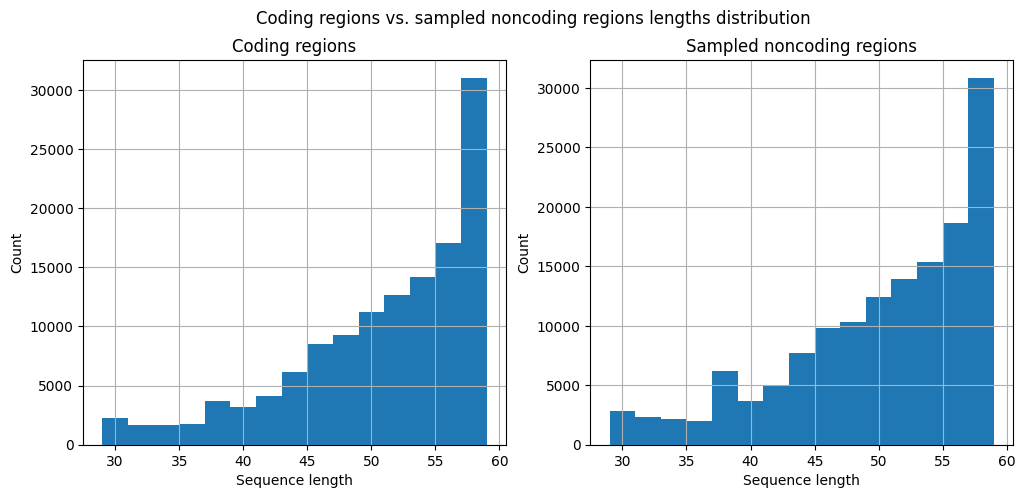

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Coding regions vs. sampled noncoding regions lengths distribution')
axes[0].set_title('Coding regions')
axes[1].set_title('Sampled noncoding regions')

axes[0].set_xlabel('Sequence length')
axes[0].set_ylabel('Count')

axes[1].set_xlabel('Sequence length')
axes[1].set_ylabel('Count')
# plt.xlabel('Count')
# plt.ylabel('Protein sequence length')

pd.Series(a).hist(bins=15, ax=axes[0])
pd.Series(b).hist(bins=15, ax=axes[1])
plt.show()

# fig.savefig('length_distribution.jpg')

# 10 fold cross validation

### loading all embeddings 

In [27]:
#getting train and test folders:
MAX_FOLD = 10
post_processed_data_PATH = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data'
all_genomes = os.listdir(post_processed_data_PATH)
all_genomes.remove('.DS_Store')


def retrieve_train_test_folders(genomes, hold_out_index):
    num_genomes = len(genomes)
    if hold_out_index == MAX_FOLD - 1:
        test_split = genomes[int((num_genomes//10) * hold_out_index): ]
        train_split = list(set(genomes) - set(test_split))
        assert len(train_split) + len(test_split) == num_genomes, "numbers do not match up!"
        return train_split, test_split
    test_split = genomes[int((num_genomes//10) * hold_out_index): int(num_genomes//10 * (hold_out_index + 1))]
    train_split = list(set(genomes) - set(test_split))
    assert len(train_split) + len(test_split) == num_genomes, "numbers do not match up!"
    return train_split, test_split
    
train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, 0)


In [22]:
random.seed(5)
torch.manual_seed(5)
def load_data(genomes):
    all_x = np.array([])
    all_y = np.array([])

    random.seed(5)
    torch.manual_seed(5)
    for genome in genomes:
        
        positive_indices = np.array(positive_filtered_genes_indices[genome]) 
        negative_indices = np.array(negative_filtered_genes_indices[genome])

        if positive_indices.shape[0] != 0:
            genome_train_coding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/coding_train_emb/train_mean.pt')
            genome_train_coding_labels = np.ones(genome_train_coding_embeddings.shape[0])[positive_indices]
            genome_train_coding_embeddings = genome_train_coding_embeddings[positive_indices]
            assert genome_train_coding_embeddings.shape[0] == len(positive_indices)

        if negative_indices.shape[0] != 0:
            genome_train_noncoding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/noncoding_test_emb/train_mean.pt')
            genome_train_noncoding_labels = np.zeros(genome_train_noncoding_embeddings.shape[0])[negative_indices]
            genome_train_noncoding_embeddings = genome_train_noncoding_embeddings[negative_indices]
            assert genome_train_noncoding_embeddings.shape[0] == len(negative_indices)

        if all_x.shape[0] == 0:
            all_x = genome_train_coding_embeddings
            all_y = genome_train_coding_labels
            all_x = np.concatenate((all_x, genome_train_noncoding_embeddings), axis=0)
            all_y = np.concatenate((all_y, genome_train_noncoding_labels), axis=0)
            continue

        if positive_indices.shape[0] != 0:
            all_x = np.concatenate((all_x, genome_train_coding_embeddings), axis=0)
            all_y = np.concatenate((all_y, genome_train_coding_labels), axis=0)
        
        if negative_indices.shape[0] != 0:
            all_x = np.concatenate((all_x, genome_train_noncoding_embeddings), axis=0)
            all_y = np.concatenate((all_y, genome_train_noncoding_labels), axis=0)
    return all_x, all_y


In [23]:
all_data_folds_embs, all_data_folds_labels = [], []
MAX_FOLD = 10
for i in range(0, MAX_FOLD, 1):
    train_split, test_split = retrieve_train_test_folders(genomes, i)
    embs, labels = load_data(test_split)
    all_data_folds_embs.append(embs)
    all_data_folds_labels.append(labels)
    

In [24]:
# sub_positive_filtered_genes = {k:v for k, v in positive_filtered_genes.items() if k in retrieve_train_test_folders(genomes, 0)[1]}
# sub_negative_filtered_genes = {k:v for k, v in negative_filtered_genes.items() if k in retrieve_train_test_folders(genomes, 0)[1]}


Note that after applying filters, some of the genomes have no coding regions or noncoding regions

In [25]:
#sanity check that the dimension of the loaded data is equal to the dimension of the indices in the dictionary
assert np.vstack(all_data_folds_embs).shape[0] == len(flatten(positive_filtered_genes.values())) + len(flatten(negative_filtered_genes.values()))


In [101]:
empty_positive_genomes = []
for genome in genomes:
    if not positive_filtered_genes_indices[genome]:
        empty_positive_genomes.append(genome)
        print(genome)
        print('none!')
    

GCF_018406645.1_ASM1840664v1
none!
GCF_017896245.1_ASM1789624v1
none!
GCF_002850495.1_ASM285049v1
none!
GCF_018467135.1_ASM1846713v1
none!
GCF_011455875.1_ASM1145587v1
none!
GCF_002804025.1_ASM280402v1
none!


In [102]:
empty_negative_genomes = []
for genome in genomes:
    if not negative_filtered_genes_indices[genome]:
        empty_negative_genomes.append(genome)
        print(genome)
        print('none!')

GCF_000287275.1_ASM28727v1
none!
GCF_001447915.1_ASM144791v1
none!


## training clasifier

In [26]:
#loading classifier:
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

class Net1(nn.Module):
  def __init__(self,input_shape):
    super(Net1,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,128)
    self.fc4 = nn.Linear(128,64)
    self.fc5 = nn.Linear(64,32)
    self.fc6 = nn.Linear(32,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)
    torch.nn.init.xavier_uniform_(self.fc6.weight)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.sigmoid(self.fc6(x))
    return x

class Net3(nn.Module):
  def __init__(self,input_shape):
    super(Net3,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    
  def forward(self,x):
    x = torch.sigmoid(self.fc1(x))
    return x

class Net4(nn.Module):
  def __init__(self,input_shape):
    super(Net4,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,128)
    self.fc2 = nn.Linear(128,256)
    self.fc3 = nn.Linear(256,512)
    self.fc4 = nn.Linear(512,256)
    self.fc5 = nn.Linear(256,128)
    self.fc6 = nn.Linear(128,64)
    self.fc7 = nn.Linear(64,32)
    self.fc8 = nn.Linear(32,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)
    torch.nn.init.xavier_uniform_(self.fc6.weight)
    torch.nn.init.xavier_uniform_(self.fc7.weight)
    torch.nn.init.xavier_uniform_(self.fc8.weight)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = torch.sigmoid(self.fc8(x))
    return x

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

In [402]:
def create_train_test_data(all_data_folds_embs, all_data_folds_labels, fold):
    test_split = [fold]
    train_split = list(set(list(range(10))) - set([fold]))
    train_x = np.vstack([all_data_folds_embs[i] for i in train_split])
    train_y = np.concatenate([all_data_folds_labels[i] for i in train_split])
    test_x = np.vstack([all_data_folds_embs[i] for i in test_split])
    test_y = np.concatenate([all_data_folds_labels[i] for i in test_split])
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, 0)

#checking dimensions:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
    

(245544, 1280)
(245544,)
(26359, 1280)
(26359,)


In [86]:
#randomly shuffling train_x, train_y and their corresponding labels
random.seed(5)
torch.manual_seed(5)
training_indices = np.arange(train_x.shape[0])
test_indices = np.arange(test_x.shape[0])
np.random.shuffle(training_indices)
np.random.shuffle(test_indices)

In [87]:
train_x = train_x[training_indices]
train_y = train_y[training_indices]
test_x = test_x[test_indices]
test_y = test_y[test_indices]

In [123]:
random.seed(5)
torch.manual_seed(5)
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
trainset = dataset(train_x, train_y)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [126]:
#hyper parameters
random.seed(5)
torch.manual_seed(5)
learning_rate = 0.01
epochs = 300
# Model , Optimizer, Loss
ecoli_model = Net4(input_shape=train_x.shape[1])
optimizer = torch.optim.SGD(ecoli_model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [127]:
#forward loop
random.seed(5)
torch.manual_seed(5)
losses = []
accur = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainloader):
    
    #calculate output
    output = ecoli_model(x_train)
 
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
 
    #accuracy
    predicted = ecoli_model(torch.tensor(x_train,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == np.array(y_train)).mean()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    losses.append(loss)
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

/Users/tonytu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


epoch 0	loss : 0.35475677251815796	 accuracy : 0.825
epoch 50	loss : 0.2417881041765213	 accuracy : 0.85
epoch 100	loss : 0.23424482345581055	 accuracy : 0.85
epoch 150	loss : 0.08079352974891663	 accuracy : 0.975
epoch 200	loss : 0.030199166387319565	 accuracy : 0.975
epoch 250	loss : 0.06520775705575943	 accuracy : 0.975


# Run 10-fold cross validation

In [708]:
for epoch in range(0, 10, 1):
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, epoch)
    
    random.seed(5)
    torch.manual_seed(5)
    training_indices = np.arange(train_x.shape[0])
    test_indices = np.arange(test_x.shape[0])
    np.random.shuffle(training_indices)
    np.random.shuffle(test_indices)
    
    train_x = train_x[training_indices]
    train_y = train_y[training_indices]
    test_x = test_x[test_indices]
    test_y = test_y[test_indices]
    
    trainset = dataset(train_x, train_y)
    #DataLoader
    trainloader = DataLoader(trainset,batch_size=64,shuffle=False)
    
    #hyper parameters
    random.seed(5)
    torch.manual_seed(5)
    learning_rate = 0.01
    epochs = 300
    # Model , Optimizer, Loss
    ecoli_model = Net1(input_shape=train_x.shape[1])
    optimizer = torch.optim.SGD(ecoli_model.parameters(),lr=learning_rate)
    loss_fn = nn.BCELoss()
    
    random.seed(5)
    torch.manual_seed(5)
    losses = []
    accur = []
    for i in range(epochs):
      for j,(x_train,y_train) in enumerate(trainloader):

        #calculate output
        output = ecoli_model(x_train)

        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))

        #accuracy
        predicted = ecoli_model(torch.tensor(x_train,dtype=torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == np.array(y_train)).mean()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if i%50 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))
    
    #saving model
    PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(epoch) + "_genomes.pt"
    torch.save(ecoli_model, PATH)
    
    

/Users/tonytu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0	loss : 0.17696475982666016	 accuracy : 0.95
epoch 50	loss : 0.14576508104801178	 accuracy : 0.925
epoch 100	loss : 0.13810546696186066	 accuracy : 0.925
epoch 150	loss : 0.1344241350889206	 accuracy : 0.95
epoch 200	loss : 0.1285872459411621	 accuracy : 0.95
epoch 250	loss : 0.11938326060771942	 accuracy : 0.95
epoch 0	loss : 0.24542240798473358	 accuracy : 0.8727272727272727
epoch 50	loss : 0.16304725408554077	 accuracy : 0.9272727272727272
epoch 100	loss : 0.1430915892124176	 accuracy : 0.9272727272727272
epoch 150	loss : 0.14132927358150482	 accuracy : 0.9454545454545454
epoch 200	loss : 0.13264790177345276	 accuracy : 0.9454545454545454
epoch 250	loss : 0.10950611531734467	 accuracy : 0.9818181818181818
epoch 0	loss : 0.06013019010424614	 accuracy : 0.95
epoch 50	loss : 0.03936905413866043	 accuracy : 1.0
epoch 100	loss : 0.03182206302881241	 accuracy : 1.0
epoch 150	loss : 0.03195275738835335	 accuracy : 1.0
epoch 200	loss : 0.03518430143594742	 accuracy : 1.0
epoch 250	lo

## evaluating model performance (aggregate)

In [81]:
accuracies, precisions, recalls, F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
    PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(i) + "_genomes.pt"
    ecoli_model = torch.load(PATH)
    ecoli_model.eval()
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    test_output_raw = ecoli_model(torch.Tensor(test_x))
    test_output = test_output_raw.round()
    accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(f1)
    print('\n')
    

fold 0
total samples: 26359
TP: 11295
FP: 593
TN: 13380
FN: 1091
accuracy: 0.936112902613908
precision: 0.9501177658142664
recall: 0.9119166801227192
F1: 0.9306253604679905


fold 1
total samples: 28136
TP: 12162
FP: 900
TN: 13976
FN: 1098
accuracy: 0.9289877736707421
precision: 0.9310978410656867
recall: 0.9171945701357466
F1: 0.9240939138363347


fold 2
total samples: 30155
TP: 13216
FP: 1047
TN: 14780
FN: 1112
accuracy: 0.9284032498756425
precision: 0.9265932833204795
recall: 0.9223897264098269
F1: 0.9244867265922843


fold 3
total samples: 27793
TP: 12172
FP: 656
TN: 13928
FN: 1037
accuracy: 0.9390853812110963
precision: 0.9488618646710321
recall: 0.9214929214929215
F1: 0.9349771479049045


fold 4
total samples: 26517
TP: 11761
FP: 863
TN: 13014
FN: 879
accuracy: 0.9343062940754987
precision: 0.9316381495564005
recall: 0.9304588607594937
F1: 0.9310481317289423


fold 5
total samples: 27544
TP: 12336
FP: 1063
TN: 13546
FN: 599
accuracy: 0.9396601800755155
precision: 0.92066572132248

In [82]:
print(np.mean(accuracies))
print(np.mean(precisions))
print(np.mean(recalls))
print(np.mean(F1s))

print('\n')
print(np.std(accuracies))
print(np.std(precisions))
print(np.std(recalls))
print(np.std(F1s))

0.9328600372308367
0.9299770414507542
0.9284336461396399
0.9290137996412635


0.00901707379667163
0.01904660104093219
0.01213611801711675
0.008974881322393312


In [128]:
#saving model
PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/ablation_study/nine_layer_fold_0_genomes.pt"
torch.save(ecoli_model, PATH)


In [129]:
#loading model for evaluation
PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/ablation_study/nine_layer_fold_0_genomes.pt"
ecoli_model = torch.load(PATH)
ecoli_model.eval()


Net4(
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=32, bias=True)
  (fc8): Linear(in_features=32, out_features=1, bias=True)
)

In [130]:
test_output_raw = ecoli_model(torch.Tensor(test_x))
test_output = test_output_raw.round()

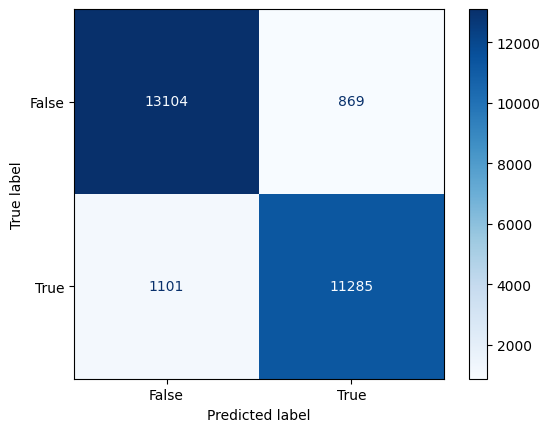

In [131]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(list(test_y), list(test_output.detach().numpy()))
# confusion_matrix = metrics.confusion_matrix(list(test_y), list(a))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.set_ticklabels_format("d")
# np.set_printoptions(suppress=True) # disable scientific notation
cm_display.plot(cmap="Blues", values_format='')
plt.show()

In [37]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    print("total samples: " + str(len(y_actual)))
    print("TP: " + str(TP))
    print("FP: " + str(FP))
    print("TN: " + str(TN))
    print("FN: " + str(FN))
    accuracy = accuracy_score(y_actual, y_hat)
    precision = precision_score(y_actual, y_hat)
    recall = recall_score(y_actual, y_hat)
    f1 = f1_score(y_actual, y_hat)
    print("accuracy: " + str(accuracy))
    print("precision: " + str(precision))
    print("recall: " + str(recall))
    print("F1: " + str(f1))
    return accuracy, precision, recall, f1

In [133]:
accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))

total samples: 26359
TP: 11285
FP: 869
TN: 13104
FN: 1101
accuracy: 0.9252627186160325
precision: 0.9285009050518348
recall: 0.9111093169707735
F1: 0.9197229013854931


# evaluating genome by genome

In [38]:
random.seed(5)
torch.manual_seed(5)
accuracies, precisions, recalls, F1s = [], [], [], []

def evaluate_by_genome(genomes, find_TP_index = False):
    PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_0_genomes.pt"
    ecoli_model = torch.load(PATH)
    ecoli_model.eval()

    random.seed(5)
    torch.manual_seed(5)
    for genome in genomes:
        print(genome)
        test_x = np.array([])
        test_y = np.array([])
        positive_indices = np.array(positive_filtered_genes_indices[genome]) 
        negative_indices = np.array(negative_filtered_genes_indices[genome])
        if positive_indices.shape[0] == 0 or negative_indices.shape[0] == 0:
            continue

        genome_train_coding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/coding_train_emb/train_mean.pt')
        genome_train_coding_labels = np.ones(genome_train_coding_embeddings.shape[0])[positive_indices]
        genome_train_coding_embeddings = genome_train_coding_embeddings[positive_indices]
        assert genome_train_coding_embeddings.shape[0] == len(positive_indices)

        genome_train_noncoding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/noncoding_test_emb/train_mean.pt')
        genome_train_noncoding_labels = np.zeros(genome_train_noncoding_embeddings.shape[0])[negative_indices]
        genome_train_noncoding_embeddings = genome_train_noncoding_embeddings[negative_indices]
        assert genome_train_noncoding_embeddings.shape[0] == len(negative_indices)
        
        if test_x.shape[0] == 0:
            test_x = genome_train_coding_embeddings
            test_y = genome_train_coding_labels
            test_x = np.concatenate((test_x, genome_train_noncoding_embeddings), axis=0)
            test_y = np.concatenate((test_y, genome_train_noncoding_labels), axis=0)

        test_output_raw = ecoli_model(torch.Tensor(test_x))
        test_output = test_output_raw.round()
        
        if find_TP_index:
            print(len(test_y))
            print(sum(test_y))
            print(len(test_y) - sum(test_y))
            print([i - int(sum(test_y)) for i in range(len(test_output)) if test_output[i] == 1 and test_y[i] == 0])
    
        accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        F1s.append(f1)

evaluate_by_genome(genomes[:100], True)
        

GCF_000283915.1_ASM28391v1
98
48.0
50.0
[9, 21]
total samples: 98
TP: 27
FP: 2
TN: 48
FN: 21
accuracy: 0.7653061224489796
precision: 0.9310344827586207
recall: 0.5625
F1: 0.7012987012987013
GCF_002056795.1_ASM205679v1
66
33.0
33.0
[3, 6, 10, 13, 25]
total samples: 66
TP: 32
FP: 5
TN: 28
FN: 1
accuracy: 0.9090909090909091
precision: 0.8648648648648649
recall: 0.9696969696969697
F1: 0.9142857142857143
GCF_009734425.1_ASM973442v1
42
20.0
22.0
[8]
total samples: 42
TP: 20
FP: 1
TN: 21
FN: 0
accuracy: 0.9761904761904762
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_003097575.1_ASM309757v1
31
16.0
15.0
[]
total samples: 31
TP: 14
FP: 0
TN: 15
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_900476035.1_53694_C01
36
16.0
20.0
[]
total samples: 36
TP: 15
FP: 0
TN: 20
FN: 1
accuracy: 0.9722222222222222
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_007750855.1_ASM775085v1
30
15.0
15.0
[0]
total samples: 30
TP: 14
FP: 1
TN:

accuracy: 0.9473684210526315
precision: 0.9444444444444444
recall: 0.9444444444444444
F1: 0.9444444444444444
GCF_000953655.1_LHA
50
25.0
25.0
[]
total samples: 50
TP: 21
FP: 0
TN: 25
FN: 4
accuracy: 0.92
precision: 1.0
recall: 0.84
F1: 0.9130434782608696
GCF_000828915.1_ASM82891v1
23
10.0
13.0
[]
total samples: 23
TP: 10
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_014217335.1_ASM1421733v1
24
12.0
12.0
[]
total samples: 24
TP: 12
FP: 0
TN: 12
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002243665.1_ASM224366v1
185
81.0
104.0
[28, 82, 87]
total samples: 185
TP: 73
FP: 3
TN: 101
FN: 8
accuracy: 0.9405405405405406
precision: 0.9605263157894737
recall: 0.9012345679012346
F1: 0.9299363057324841
GCF_003265305.2_ASM326530v2
16
8.0
8.0
[]
total samples: 16
TP: 8
FP: 0
TN: 8
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003851555.1_ASM385155v1
86
37.0
49.0
[13, 36, 39, 48]
total samples: 86
TP: 35
FP: 4
TN: 45
FN: 2
accuracy: 0.9302325581395

In [826]:
print(np.mean(accuracies), np.std(accuracies))
print(np.mean(precisions), np.std(precisions))
print(np.mean(recalls), np.std(recalls))
print(np.mean(F1s), np.std(F1s))



0.807382181505154 0.08080859075054792
0.9557485970819304 0.034604080809111544
0.6634324374849281 0.2134564478055572
0.7589389564582983 0.14515720502173257


## random classifier (baseline)

In [747]:
def generate_random_vector(x):
    vector = []
    for _ in range(x):
        element = random.choice([0, 1])
        vector.append(element)
    return vector

random_accuracies, random_precisions, random_recalls, random_f1s = [], [], [], [] 

random.seed(5)
#since data is not completely balanced, we need to add a baseline which predicts labels randomly. 
for i in range(10):
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    print(train_x.shape)
    print(test_x.shape)
    random_vector = generate_random_vector(len(test_y))
    random_accuracy, random_precision, random_recall, random_f1 = perf_measure(list(test_y), list(random_vector))
    random_recalls.append(random_recall)
    random_accuracies.append(random_accuracy)
    random_precisions.append(random_precision)
    random_f1s.append(random_f1)
    


(245544, 1280)
(26359, 1280)
total samples: 26359
TP: 6223
FP: 7078
TN: 6895
FN: 6163
accuracy: 0.49766683106339393
precision: 0.46785955943162166
recall: 0.5024220894558372
F1: 0.4845252462335033
(243767, 1280)
(28136, 1280)
total samples: 28136
TP: 6633
FP: 7411
TN: 7465
FN: 6627
accuracy: 0.5010662496445835
precision: 0.47230133864995727
recall: 0.5002262443438914
F1: 0.48586287723410493
(241748, 1280)
(30155, 1280)
total samples: 30155
TP: 7217
FP: 7974
TN: 7853
FN: 7111
accuracy: 0.49975128502735866
precision: 0.47508393127509707
recall: 0.5036990508096035
F1: 0.48897320369931224
(244110, 1280)
(27793, 1280)
total samples: 27793
TP: 6589
FP: 7258
TN: 7326
FN: 6620
accuracy: 0.5006656352318929
precision: 0.47584314291904384
recall: 0.49882655765008704
F1: 0.4870638675340035
(245386, 1280)
(26517, 1280)
total samples: 26517
TP: 6242
FP: 6990
TN: 6887
FN: 6398
accuracy: 0.49511634046083647
precision: 0.47173518742442566
recall: 0.49382911392405066
F1: 0.4825293753865183
(244359, 1280

In [748]:
print(np.mean(random_accuracies), np.std(random_accuracies))
print(np.mean(random_precisions), np.std(random_precisions))
print(np.mean(random_recalls), np.std(random_recalls))
print(np.mean(random_f1s), np.std(random_f1s))

0.49938771095139967 0.002909228019437151
0.47235386543608826 0.0024551607781829036
0.501439262100752 0.0036040333950898454
0.4864537041303881 0.0022595000503375763


## GeneMark Evaluation

In [603]:
def find_train_val_genome_indices(hold_out_index):
    num_genomes = len(all_genomes)
    test_split = np.arange(int((num_genomes//10) * hold_out_index), int(num_genomes//10 * (hold_out_index + 1)), 1)
    all_indices = np.arange(0, num_genomes, 1)
    train_split = np.array(list(set(all_indices) - set(test_split)))
    
    if hold_out_index == MAX_FOLD - 1:
        test_split = np.arange(int((num_genomes//10) * hold_out_index), num_genomes, 1)
        all_indices = np.arange(0, num_genomes, 1)
        train_split = np.array(list(set(all_indices) - set(test_split)))
    return np.array(all_genomes)[train_split], np.array(all_genomes)[test_split]
#     print(len(test_split))

In [247]:
#evaluating on positive strand: 
def positive_strand_inference_evaluate(groundtruths, predictions):
    exact_matches = 0
    results = []
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    none = 0
    
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('5 prime match, 3 prime mismatch!')
                continue
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('5 prime mismatch, 3 prime match!')
                continue
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_genemark_prediction)


In [248]:

def negative_strand_inference_evaluate(groundtruths, predictions):
    results = []
    exact_matches = 0
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    five_prime_mismatch_indices = []
    three_prime_mismatch_indices = []
    none = 0
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('3 prime match, 5 prime mismatch!')
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('3 prime mismatch, 5 prime match!') 
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_genemark_prediction)


In [249]:
#evaluating on positive strand: 
def noncoding_positive_strand_inference_evaluate(groundtruths, predictions):
    exact_matches = 0
    results = []
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    none = 0
    
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('5 prime match, 3 prime mismatch!')
                continue
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('5 prime mismatch, 3 prime match!')
                continue
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_genemark_prediction)


In [250]:
def noncoding_negative_strand_inference_evaluate(groundtruths, predictions):
    results = []
    exact_matches = 0
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    five_prime_mismatch_indices = []
    three_prime_mismatch_indices = []
    none = 0
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('3 prime match, 5 prime mismatch!')
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('3 prime mismatch, 5 prime match!') 
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_genemark_prediction)


In [258]:
def read_noncod_fasta(dir_name, genome_name, file_name, training_indices):
    #'sampled_genomes_resampled/'
    f=open(str(dir_name) + '/' + str(genome_name) + '/' + file_name,'r')
    lines=f.readlines()

    information_lines = []
    sequence_lines = []
    
    positive_strand_noncoding_training_lines = []
    negative_strand_noncoding_training_lines = []
    for line in lines:
        if line.startswith('>'):
            information_lines.append(line)
        elif line.startswith('M'):
            sequence_lines.append(line)
    assert len(information_lines) == len(sequence_lines)
    for training_index in training_indices:
        information_line = information_lines[training_index]
        if information_line.endswith('(REVERSE SENSE) \n'):
            negative_strand_noncoding_training_lines.append([int(information_line.split(' ')[1][1:]), int(information_line.split(' ')[3][:-1])])
        else:
            positive_strand_noncoding_training_lines.append([int(information_line.split(' ')[1][1:]), int(information_line.split(' ')[3][:-1])])
    return positive_strand_noncoding_training_lines, negative_strand_noncoding_training_lines
    

In [600]:
def find_seqs_updated_negative(test_genomes, algorithm="GMS"):
    all_results = []
    all_groundtruths = []
    
    for genome in test_genomes: 
        if algorithm == 'GMS':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/gms2/gms2.gff'
            
        elif algorithm == 'prodigal':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/prodigal/output.gff'
            
        elif algorithm == 'FGS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'
            
        training_short_groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/filtered_short.gff'
#         groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/annot.gff'
        #short groundtruths
        groundtruth = gffpd.read_gff3(training_short_groundtruth_path)
        groundtruth_df = groundtruth.df
        # short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
        short_groundtruth_df = groundtruth_df
        positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
        negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']
        
        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
        
        #short genes

        gene_ids, sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'short.fasta')
        
        training_sequences = positive_filtered_genes[genome]
        seqs_indices = find_indices(training_sequences, sequences)
        training_gene_ids = [gene_ids[i] for i in seqs_indices]

        positive_training_indices = []
        negative_training_indices = []
        for i in range(positive_strand_short_groundtruth.shape[0]):
            if positive_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                positive_training_indices.append(i)

        for i in range(negative_strand_short_groundtruth.shape[0]):
            if negative_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                negative_training_indices.append(i)
    
        positive_strand_short_groundtruth = positive_strand_short_groundtruth.iloc[positive_training_indices]
        negative_strand_short_groundtruth = negative_strand_short_groundtruth.iloc[negative_training_indices]

        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
        
#         print(len(positive_short_groundtruth))
#         print(len(negative_short_groundtruth))

        prediction = gffpd.read_gff3(prediction_path)
        results = list(prediction.df['seq_id'])
        prediction_df = prediction.df
        short_prediction_df = prediction_df[prediction_df['end'] - prediction_df['start'] < 180]
        positive_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '+']
        negative_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '-']

        positive_short_prediction = positive_strand_short_prediction_df[['start', 'end']].values.tolist()
        negative_short_prediction = negative_strand_short_prediction_df[['start', 'end']].values.tolist()
    
        #repeat the exact same thing for noncoding regions
        non_gene_ids, non_coding_sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'noncod_short.fasta')
        training_noncod_sequences = negative_filtered_genes[genome]
        noncoding_seqs_indices = find_indices(training_noncod_sequences, non_coding_sequences)
        
#         training_non_coding_ids = [non_gene_ids[i] for i in noncoding_seqs_indices]
        positive_strand_noncoding_groundtruth, negative_strand_noncoding_groundtruth = read_noncod_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'noncod_short.fasta', noncoding_seqs_indices)
        assert len(positive_strand_noncoding_groundtruth) + len(negative_strand_noncoding_groundtruth) == len(negative_filtered_genes[genome])
        

        positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = noncoding_positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_prediction)
        negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = noncoding_negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_prediction)

        total_exact_match, total_detect_5, total_detect_3, total_none, results = (negative_exact_match + positive_exact_match, 
            positive_detect_5 + negative_detect_5, 
            positive_detect_3 + negative_detect_3, 
            positive_none + negative_none, 
            positive_results + negative_results)
        
        
        
        noncoding_positive_exact_match, noncoding_positive_detect_5, noncoding_positive_detect_3, noncoding_positive_none, noncoding_positive_results = noncoding_positive_strand_inference_evaluate(positive_strand_noncoding_groundtruth, positive_short_prediction)
        noncoding_negative_exact_match, noncoding_negative_detect_5, noncoding_negative_detect_3, noncoding_negative_none, noncoding_negative_results = noncoding_negative_strand_inference_evaluate(negative_strand_noncoding_groundtruth, negative_short_prediction)

        noncoding_total_exact_match, noncoding_total_detect_5, noncoding_total_detect_3, noncoding_total_none, noncoding_results = (noncoding_negative_exact_match + noncoding_positive_exact_match, 
            noncoding_positive_detect_5 + noncoding_negative_detect_5, 
            noncoding_positive_detect_3 + noncoding_negative_detect_3, 
            noncoding_positive_none + noncoding_negative_none, 
            noncoding_positive_results + noncoding_negative_results)
        
        training_noncoding_sequences = negative_filtered_genes[genome]
        final_groundtruth = len(results) * [1] + len(negative_filtered_genes[genome]) * [0]
        results = results + noncoding_results
        all_results.extend(results)
        all_groundtruths.extend(final_groundtruth)
    assert len(all_results) == len(all_groundtruths), 'array size dont match up!'
    return all_results, all_groundtruths

In [118]:
def read_fasta(dir_name, genome_name, file_name):
    #'sampled_genomes_resampled/'
    f=open(str(dir_name) + '/' + str(genome_name) + '/' + file_name,'r')
    lines=f.readlines()

    hre=re.compile('>(\S+)')
    lre=re.compile('^(\S+)$')

    gene={}

    for line in lines:
            outh = hre.search(line)
            if outh:
                    id=outh.group(1)
            else:
                    outl=lre.search(line)
                    if(id in gene.keys()):
                            gene[id] += outl.group(1)
                    else:
                            gene[id]  =outl.group(1)
    return list(gene.keys()), list(gene.values())

def find_indices(a, b):
    """
    Returns a list of indices that corresponds to the index of every element of a in b.
    """
    indices = []
    for element in a:
        if element in b:
            index = b.index(element)
            indices.append(index)
    return indices

def find_seqs(test_genomes, algorithm="GMS"):
    all_results = []
    all_groundtruths = []
    
    for genome in test_genomes: 
        if algorithm == 'GMS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/FLIP-main_latest/baselines/embeddings/gb1/esm1b/two_vs_rest/post_processed_data/' + genome + '/gms2/gms2.gff'
            
        elif algorithm == 'prodigal':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/FLIP-main_latest/baselines/embeddings/gb1/esm1b/two_vs_rest/post_processed_data/' + genome + '/prodigal/output.gff'
            
        elif algorithm == 'FGS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'
            
        training_short_groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/filtered_short.gff'
#         groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/annot.gff'
        #short groundtruths
        groundtruth = gffpd.read_gff3(training_short_groundtruth_path)
        groundtruth_df = groundtruth.df
        # short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
        short_groundtruth_df = groundtruth_df
        positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
        negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']
        
        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
        
        gene_ids, sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'short.fasta')
        
        training_sequences = positive_filtered_genes[genome]
        seqs_indices = find_indices(training_sequences, sequences)
        training_gene_ids = [gene_ids[i] for i in seqs_indices]

        positive_training_indices = []
        negative_training_indices = []
        for i in range(positive_strand_short_groundtruth.shape[0]):
            if positive_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                positive_training_indices.append(i)

        for i in range(negative_strand_short_groundtruth.shape[0]):
            if negative_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                negative_training_indices.append(i)

        positive_strand_short_groundtruth = positive_strand_short_groundtruth.iloc[positive_training_indices]
        negative_strand_short_groundtruth = negative_strand_short_groundtruth.iloc[negative_training_indices]

        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()

        prediction = gffpd.read_gff3(prediction_path)
        results = list(prediction.df['seq_id'])
        prediction_df = prediction.df
        short_prediction_df = prediction_df[prediction_df['end'] - prediction_df['start'] < 180]
        positive_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '+']
        negative_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '-']

        positive_short_prediction = positive_strand_short_prediction_df[['start', 'end']].values.tolist()
        negative_short_prediction = negative_strand_short_prediction_df[['start', 'end']].values.tolist()

        positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_prediction)
        negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_prediction)

        total_exact_match, total_detect_5, total_detect_3, total_none, results = (negative_exact_match + positive_exact_match, 
            positive_detect_5 + negative_detect_5, 
            positive_detect_3 + negative_detect_3, 
            positive_none + negative_none, 
            positive_results + negative_results)
        
        training_noncoding_sequences = negative_filtered_genes[genome]
        final_groundtruth = len(results) * [1] + len(negative_filtered_genes[genome]) * [0]
        results = results + len(negative_filtered_genes[genome]) * [0]
        all_results.extend(results)
        all_groundtruths.extend(final_groundtruth)
    assert len(all_results) == len(all_groundtruths), 'array size dont match up!'
    return all_results, all_groundtruths
        
# genemark_results, groundtruth_results = find_seqs(['GCF_001880225.1_ASM188022v1'])          


## Genemark 10 fold cross validation

In [79]:
for i in range(10):
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    print(train_x.shape)
    print(test_x.shape)

(245544, 1280)
(26359, 1280)
(243767, 1280)
(28136, 1280)
(241748, 1280)
(30155, 1280)
(244110, 1280)
(27793, 1280)
(245386, 1280)
(26517, 1280)
(244359, 1280)
(27544, 1280)
(246605, 1280)
(25298, 1280)
(244532, 1280)
(27371, 1280)
(245299, 1280)
(26604, 1280)
(245777, 1280)
(26126, 1280)


In [431]:
genemark_accuracies, genemark_precisions, genemark_recalls, genemark_F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
    train_genomes, test_genomes = find_train_val_genome_indices(i)
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    genemark_results, groundtruth_results = find_seqs_updated_negative(test_genomes, 'GMS')
    assert(test_x.shape[0] == len(groundtruth_results))
    print("number of test genomes: " + str(len(groundtruth_results)))
    genemark_accuracy, genemark_precision, genemark_recall, genemark_f1 = perf_measure(list(groundtruth_results), list(genemark_results))
    genemark_accuracies.append(genemark_accuracy)
    genemark_precisions.append(genemark_precision)
    genemark_recalls.append(genemark_recall)
    genemark_F1s.append(genemark_f1)
    print('\n')
    

fold 0
number of test genomes: 26359
total samples: 26359
TP: 9910
FP: 0
TN: 13973
FN: 2476
accuracy: 0.9060662392351758
precision: 1.0
recall: 0.8000968835782335
F1: 0.8889486903480445


fold 1
number of test genomes: 28136
total samples: 28136
TP: 10566
FP: 0
TN: 14876
FN: 2694
accuracy: 0.9042507819164061
precision: 1.0
recall: 0.7968325791855203
F1: 0.8869302442709646


fold 2
number of test genomes: 30155
total samples: 30155
TP: 11259
FP: 0
TN: 15827
FN: 3069
accuracy: 0.8982258331951584
precision: 1.0
recall: 0.7858040201005025
F1: 0.8800562785789658


fold 3
number of test genomes: 27793
total samples: 27793
TP: 10710
FP: 0
TN: 14584
FN: 2499
accuracy: 0.9100852732702479
precision: 1.0
recall: 0.8108108108108109
F1: 0.8955223880597014


fold 4
number of test genomes: 26517
total samples: 26517
TP: 10177
FP: 0
TN: 13877
FN: 2463
accuracy: 0.9071161896142097
precision: 1.0
recall: 0.8051424050632912
F1: 0.8920541701363018


fold 5
number of test genomes: 27544
total samples: 2754

In [455]:
print(np.mean(genemark_accuracies), np.std(genemark_accuracies))
print(np.mean(genemark_precisions), np.std(genemark_precisions))
print(np.mean(genemark_recalls), np.std(genemark_recalls))
print(np.mean(genemark_F1s), np.std(genemark_F1s))

0.9097165474654444 0.005905607936273552
1.0 0.0
0.8090887394664252 0.012099700790742136
0.8944214671674902 0.0074114571633811166


## prodigal 10 fold cross validation

In [465]:
prodigal_accuracies, prodigal_precisions, prodigal_recalls, prodigal_F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
    train_genomes, test_genomes = find_train_val_genome_indices(i)
    prodigal_results, groundtruth_results = find_seqs_updated_negative(test_genomes, 'prodigal')
    prodigal_accuracy, prodigal_precision, prodigal_recall, prodigal_f1 = perf_measure(list(groundtruth_results), list(prodigal_results))
    prodigal_accuracies.append(prodigal_accuracy)
    prodigal_precisions.append(prodigal_precision)
    prodigal_recalls.append(prodigal_recall)
    prodigal_F1s.append(prodigal_f1)
    print('\n')
    

fold 0
total samples: 26359
TP: 9477
FP: 3
TN: 13970
FN: 2909
accuracy: 0.8895253992943587
precision: 0.9996835443037975
recall: 0.7651380590989827
F1: 0.8668252080856124


fold 1
total samples: 28136
TP: 10056
FP: 0
TN: 14876
FN: 3204
accuracy: 0.8861245379584873
precision: 1.0
recall: 0.7583710407239819
F1: 0.8625836335563561


fold 2
total samples: 30155
TP: 10824
FP: 2
TN: 15825
FN: 3504
accuracy: 0.8837340407892555
precision: 0.9998152595603178
recall: 0.7554438860971524
F1: 0.8606185894887494


fold 3
total samples: 27793
TP: 10295
FP: 2
TN: 14582
FN: 2914
accuracy: 0.8950814953405534
precision: 0.9998057686704865
recall: 0.7793928382163676
F1: 0.8759465668339999


fold 4
total samples: 26517
TP: 9684
FP: 3
TN: 13874
FN: 2956
accuracy: 0.8884112079043632
precision: 0.9996903065964695
recall: 0.7661392405063291
F1: 0.8674698795180723


fold 5
total samples: 27544
TP: 10096
FP: 1
TN: 14608
FN: 2839
accuracy: 0.8968922451350566
precision: 0.9999009606813906
recall: 0.780517974487823

In [466]:
print(np.mean(prodigal_accuracies), np.std(prodigal_accuracies))
print(np.mean(prodigal_precisions), np.std(prodigal_precisions))
print(np.mean(prodigal_recalls), np.std(prodigal_recalls))
print(np.mean(prodigal_F1s), np.std(prodigal_F1s))



0.8923667325641331 0.0054517318985700955
0.9998588145360259 0.00011409212921953041
0.772495185769595 0.011169747395698287
0.8715489971985055 0.007129949891503465


## FragGeneScan 10-fold cross validation:


In [471]:
FGS_accuracies, FGS_precisions, FGS_recalls, FGS_F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
    train_genomes, test_genomes = find_train_val_genome_indices(i)
    FGS_results, groundtruth_results = find_seqs_updated_negative(test_genomes, 'FGS')
    FGS_accuracy, FGS_precision, FGS_recall, FGS_f1 = perf_measure(list(groundtruth_results), list(FGS_results))
    FGS_accuracies.append(FGS_accuracy)
    FGS_precisions.append(FGS_precision)
    FGS_recalls.append(FGS_recall)
    FGS_F1s.append(FGS_f1)
    print('\n')
    

fold 0
total samples: 26359
TP: 6803
FP: 0
TN: 13973
FN: 5583
accuracy: 0.7881937858037104
precision: 1.0
recall: 0.5492491522686904
F1: 0.7090520610766585


fold 1
total samples: 28136
TP: 7245
FP: 0
TN: 14876
FN: 6015
accuracy: 0.7862169462610179
precision: 1.0
recall: 0.5463800904977375
F1: 0.7066569129480614


fold 2
total samples: 30155
TP: 7696
FP: 0
TN: 15827
FN: 6632
accuracy: 0.7800696401923396
precision: 1.0
recall: 0.5371300949190396
F1: 0.6988739556847076


fold 3
total samples: 27793
TP: 7225
FP: 0
TN: 14584
FN: 5984
accuracy: 0.7846939876947433
precision: 1.0
recall: 0.546975546975547
F1: 0.7071547420965059


fold 4
total samples: 26517
TP: 6985
FP: 0
TN: 13877
FN: 5655
accuracy: 0.7867405815137459
precision: 1.0
recall: 0.5526107594936709
F1: 0.7118471337579618


fold 5
total samples: 27544
TP: 7440
FP: 0
TN: 14609
FN: 5495
accuracy: 0.8005010165553297
precision: 1.0
recall: 0.5751836103594897
F1: 0.7303067484662576


fold 6
total samples: 25298
TP: 6750
FP: 0
TN: 13333


In [472]:
print(np.mean(FGS_accuracies), np.std(FGS_accuracies))
print(np.mean(FGS_precisions), np.std(FGS_precisions))
print(np.mean(FGS_recalls), np.std(FGS_recalls))
print(np.mean(FGS_F1s), np.std(FGS_F1s))


0.7897969641441805 0.005968341364706022
1.0 0.0
0.5554834241490606 0.011400486339689767
0.7141571563680573 0.00940591494132429


# (camera ready) evaluating genome-wise on models trained on other folds protigeno

In [39]:
PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(fold_index) + "_genomes.pt"
ecoli_model = torch.load(PATH)
ecoli_model.eval()

Net1(
  (fc1): Linear(in_features=1280, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
)

In [105]:
fold_genome_names = []
accuracies = []
precisions = []
recalls = []
F1s = []
def evaluate_by_genome_camera_ready(all_genomes, fold_index, find_TP_index = False):
    random.seed(5)
    torch.manual_seed(5)
    train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, fold_index)
    print('total train genomes: ' + str(len(train_genomes)))
    print('total test genomes: ' + str(len(test_genomes)))
    for genome in test_genomes:
        print(genome)
        test_x = np.array([])
        test_y = np.array([])
        positive_indices = np.array(positive_filtered_genes_indices[genome]) 
        negative_indices = np.array(negative_filtered_genes_indices[genome])
        if positive_indices.shape[0] == 0 or negative_indices.shape[0] == 0:
            continue

        genome_train_coding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/coding_train_emb/train_mean.pt')
        genome_train_coding_labels = np.ones(genome_train_coding_embeddings.shape[0])[positive_indices]
        genome_train_coding_embeddings = genome_train_coding_embeddings[positive_indices]
        assert genome_train_coding_embeddings.shape[0] == len(positive_indices)

        genome_train_noncoding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/noncoding_test_emb/train_mean.pt')
        genome_train_noncoding_labels = np.zeros(genome_train_noncoding_embeddings.shape[0])[negative_indices]
        genome_train_noncoding_embeddings = genome_train_noncoding_embeddings[negative_indices]
        assert genome_train_noncoding_embeddings.shape[0] == len(negative_indices)
        
        if test_x.shape[0] == 0:
            test_x = genome_train_coding_embeddings
            test_y = genome_train_coding_labels
            test_x = np.concatenate((test_x, genome_train_noncoding_embeddings), axis=0)
            test_y = np.concatenate((test_y, genome_train_noncoding_labels), axis=0)

        test_output_raw = ecoli_model(torch.Tensor(test_x))
        test_output = test_output_raw.round()
        
        if find_TP_index:
            print(len(test_y))
            print(sum(test_y))
            print(len(test_y) - sum(test_y))
            print([i - int(sum(test_y)) for i in range(len(test_output)) if test_output[i] == 1 and test_y[i] == 0])
    
        accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))
        fold_genome_names.append(genome)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        F1s.append(f1)
        

In [106]:
#running on all the genomes:
for i in range(10):
    evaluate_by_genome_camera_ready(all_genomes, i, find_TP_index = False)

total train genomes: 3860
total test genomes: 428
GCF_000283915.1_ASM28391v1
total samples: 98
TP: 27
FP: 2
TN: 48
FN: 21
accuracy: 0.7653061224489796
precision: 0.9310344827586207
recall: 0.5625
F1: 0.7012987012987013
GCF_002056795.1_ASM205679v1
total samples: 66
TP: 32
FP: 5
TN: 28
FN: 1
accuracy: 0.9090909090909091
precision: 0.8648648648648649
recall: 0.9696969696969697
F1: 0.9142857142857143
GCF_009734425.1_ASM973442v1
total samples: 42
TP: 20
FP: 1
TN: 21
FN: 0
accuracy: 0.9761904761904762
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_003097575.1_ASM309757v1
total samples: 31
TP: 14
FP: 0
TN: 15
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_900476035.1_53694_C01
total samples: 36
TP: 15
FP: 0
TN: 20
FN: 1
accuracy: 0.9722222222222222
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_007750855.1_ASM775085v1
total samples: 30
TP: 14
FP: 1
TN: 14
FN: 1
accuracy: 0.9333333333333333
precision: 0.9333333333333333


accuracy: 0.9333333333333333
precision: 0.8823529411764706
recall: 1.0
F1: 0.9375
GCF_000513475.1_Bbla
total samples: 8
TP: 4
FP: 0
TN: 4
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000733715.2_ASM73371v2
total samples: 70
TP: 32
FP: 2
TN: 35
FN: 1
accuracy: 0.9571428571428572
precision: 0.9411764705882353
recall: 0.9696969696969697
F1: 0.955223880597015
GCF_017310015.1_ASM1731001v1
total samples: 41
TP: 20
FP: 3
TN: 18
FN: 0
accuracy: 0.926829268292683
precision: 0.8695652173913043
recall: 1.0
F1: 0.9302325581395349
GCF_000802245.2_ASM80224v2
total samples: 99
TP: 45
FP: 0
TN: 53
FN: 1
accuracy: 0.98989898989899
precision: 1.0
recall: 0.9782608695652174
F1: 0.989010989010989
GCF_000017945.1_ASM1794v1
total samples: 15
TP: 11
FP: 1
TN: 3
FN: 0
accuracy: 0.9333333333333333
precision: 0.9166666666666666
recall: 1.0
F1: 0.9565217391304348
GCF_015277875.1_ASM1527787v1
total samples: 30
TP: 14
FP: 1
TN: 15
FN: 0
accuracy: 0.9666666666666667
precision: 0.9333333333333333
recal

total samples: 33
TP: 12
FP: 0
TN: 19
FN: 2
accuracy: 0.9393939393939394
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_900476175.1_50648_D01
total samples: 13
TP: 6
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001267925.1_ASM126792v1
total samples: 48
TP: 22
FP: 1
TN: 23
FN: 2
accuracy: 0.9375
precision: 0.9565217391304348
recall: 0.9166666666666666
F1: 0.9361702127659574
GCF_000215645.1_ASM21564v1
total samples: 46
TP: 22
FP: 0
TN: 23
FN: 1
accuracy: 0.9782608695652174
precision: 1.0
recall: 0.9565217391304348
F1: 0.9777777777777777
GCF_002243515.1_ASM224351v1
total samples: 64
TP: 25
FP: 4
TN: 30
FN: 5
accuracy: 0.859375
precision: 0.8620689655172413
recall: 0.8333333333333334
F1: 0.847457627118644
GCF_002355855.1_ASM235585v1
total samples: 82
TP: 36
FP: 2
TN: 42
FN: 2
accuracy: 0.9512195121951219
precision: 0.9473684210526315
recall: 0.9473684210526315
F1: 0.9473684210526315
GCF_900637575.1_52006_A02
total samples: 21
TP: 10
FP: 2
TN: 

accuracy: 0.9333333333333333
precision: 0.9428571428571428
recall: 0.9166666666666666
F1: 0.9295774647887323
GCF_000025685.1_ASM2568v1
total samples: 196
TP: 94
FP: 6
TN: 91
FN: 5
accuracy: 0.9438775510204082
precision: 0.94
recall: 0.9494949494949495
F1: 0.9447236180904524
GCF_001553565.1_ASM155356v1
total samples: 33
TP: 16
FP: 0
TN: 17
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001442745.1_ASM144274v1
total samples: 29
TP: 14
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_018139125.1_ASM1813912v1
total samples: 37
TP: 15
FP: 0
TN: 21
FN: 1
accuracy: 0.972972972972973
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_014490555.1_ASM1449055v1
total samples: 30
TP: 13
FP: 0
TN: 17
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_008693785.1_ASM869378v1
total samples: 35
TP: 14
FP: 0
TN: 21
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000255115.2_ASM25511v3
total samples: 132
TP: 64
FP: 3
TN: 63
FN: 2
accuracy: 0.962

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000833355.1_ASM83335v1
total samples: 40
TP: 12
FP: 3
TN: 20
FN: 5
accuracy: 0.8
precision: 0.8
recall: 0.7058823529411765
F1: 0.7500000000000001
GCF_013415885.1_ASM1341588v1
total samples: 152
TP: 74
FP: 6
TN: 71
FN: 1
accuracy: 0.9539473684210527
precision: 0.925
recall: 0.9866666666666667
F1: 0.9548387096774195
GCF_900475675.1_45473_D02
total samples: 58
TP: 20
FP: 2
TN: 31
FN: 5
accuracy: 0.8793103448275862
precision: 0.9090909090909091
recall: 0.8
F1: 0.8510638297872342
GCF_001545155.1_ASM154515v1
total samples: 66
TP: 30
FP: 0
TN: 33
FN: 3
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
GCF_900636885.1_44927_H01
total samples: 90
TP: 44
FP: 4
TN: 41
FN: 1
accuracy: 0.9444444444444444
precision: 0.9166666666666666
recall: 0.9777777777777777
F1: 0.946236559139785
GCF_000243155.2_ASM24315v3
total samples: 146
TP: 58
FP: 5
TN: 72
FN: 11
accuracy: 0.8904109589041096
precision: 0.92063492

accuracy: 0.9166666666666666
precision: 0.9259259259259259
recall: 0.8928571428571429
F1: 0.9090909090909091
GCF_000470775.1_ASM47077v1
total samples: 41
TP: 18
FP: 0
TN: 21
FN: 2
accuracy: 0.9512195121951219
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_000280925.3_ASM28092v3
total samples: 112
TP: 46
FP: 0
TN: 58
FN: 8
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8518518518518519
F1: 0.92
GCF_005484945.1_ASM548494v1
total samples: 63
TP: 27
FP: 2
TN: 31
FN: 3
accuracy: 0.9206349206349206
precision: 0.9310344827586207
recall: 0.9
F1: 0.9152542372881356
GCF_024072275.1_ASM2407227v1
total samples: 58
TP: 12
FP: 0
TN: 45
FN: 1
accuracy: 0.9827586206896551
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_003431825.1_ASM343182v1
total samples: 77
TP: 38
FP: 1
TN: 38
FN: 0
accuracy: 0.987012987012987
precision: 0.9743589743589743
recall: 1.0
F1: 0.9870129870129869
GCF_018207515.1_ASM1820751v1
total samples: 133
TP: 60
FP: 3
TN: 68
FN: 2
accuracy: 0.96240

total samples: 38
TP: 19
FP: 1
TN: 18
FN: 0
accuracy: 0.9736842105263158
precision: 0.95
recall: 1.0
F1: 0.9743589743589743
GCF_000196535.1_ASM19653v1
total samples: 39
TP: 15
FP: 1
TN: 19
FN: 4
accuracy: 0.8717948717948718
precision: 0.9375
recall: 0.7894736842105263
F1: 0.8571428571428572
GCF_003611035.1_ASM361103v1
total samples: 20
TP: 9
FP: 1
TN: 10
FN: 0
accuracy: 0.95
precision: 0.9
recall: 1.0
F1: 0.9473684210526316
GCF_002688605.1_ASM268860v1
total samples: 359
TP: 156
FP: 15
TN: 165
FN: 23
accuracy: 0.8941504178272981
precision: 0.9122807017543859
recall: 0.8715083798882681
F1: 0.8914285714285715
GCF_001895265.1_ASM189526v1
total samples: 23
TP: 8
FP: 0
TN: 13
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_003070885.1_ASM307088v1
total samples: 28
TP: 12
FP: 2
TN: 13
FN: 1
accuracy: 0.8928571428571429
precision: 0.8571428571428571
recall: 0.9230769230769231
F1: 0.888888888888889
GCF_018604565.1_ASM1860456v1
total samples: 73
TP: 33
FP:

total samples: 13
TP: 8
FP: 0
TN: 3
FN: 2
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_016889385.1_ASM1688938v1
total samples: 31
TP: 14
FP: 1
TN: 16
FN: 0
accuracy: 0.967741935483871
precision: 0.9333333333333333
recall: 1.0
F1: 0.9655172413793104
GCF_900120245.1_PRJEB17949
total samples: 24
TP: 11
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001606025.1_ASM160602v1
total samples: 31
TP: 13
FP: 0
TN: 17
FN: 1
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_013004005.1_ASM1300400v1
total samples: 40
TP: 20
FP: 1
TN: 19
FN: 0
accuracy: 0.975
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_002892185.1_ASM289218v1
total samples: 46
TP: 16
FP: 1
TN: 29
FN: 0
accuracy: 0.9782608695652174
precision: 0.9411764705882353
recall: 1.0
F1: 0.9696969696969697
GCF_020735705.1_ASM2073570v1
total samples: 69
TP: 32
FP: 0
TN: 36
FN: 1
accuracy: 0.9855072463768116
precision

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000019905.1_ASM1990v1
total samples: 81
TP: 38
FP: 2
TN: 39
FN: 2
accuracy: 0.9506172839506173
precision: 0.95
recall: 0.95
F1: 0.9500000000000001
GCF_000973545.1_ASM97354v1
total samples: 12
TP: 6
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_013752735.1_ASM1375273v1
total samples: 216
TP: 94
FP: 3
TN: 113
FN: 6
accuracy: 0.9583333333333334
precision: 0.9690721649484536
recall: 0.94
F1: 0.9543147208121826
GCF_016939435.1_ASM1693943v1
total samples: 203
TP: 94
FP: 1
TN: 103
FN: 5
accuracy: 0.9704433497536946
precision: 0.9894736842105263
recall: 0.9494949494949495
F1: 0.9690721649484537
GCF_010731735.1_ASM1073173v1
total samples: 97
TP: 46
FP: 2
TN: 49
FN: 0
accuracy: 0.979381443298969
precision: 0.9583333333333334
recall: 1.0
F1: 0.9787234042553191
GCF_005222125.1_ASM522212v1
total samples: 50
TP: 22
FP: 4
TN: 23
FN: 1
accuracy: 0.9
precision: 0.8461538461538461
recall: 0.9565217391304348
F1: 0.8979591836734

total samples: 18
TP: 5
FP: 1
TN: 10
FN: 2
accuracy: 0.8333333333333334
precision: 0.8333333333333334
recall: 0.7142857142857143
F1: 0.7692307692307692
GCF_002843235.3_ASM284323v3
total samples: 77
TP: 35
FP: 0
TN: 41
FN: 1
accuracy: 0.987012987012987
precision: 1.0
recall: 0.9722222222222222
F1: 0.9859154929577464
GCF_000024405.1_ASM2440v1
total samples: 44
TP: 22
FP: 3
TN: 19
FN: 0
accuracy: 0.9318181818181818
precision: 0.88
recall: 1.0
F1: 0.9361702127659575
GCF_902459485.1_pb_189-2_HGAP3_CTR
total samples: 18
TP: 9
FP: 0
TN: 9
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003966975.1_ASM396697v1
total samples: 18
TP: 8
FP: 0
TN: 9
FN: 1
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_018138125.1_ASM1813812v1
total samples: 56
TP: 26
FP: 2
TN: 28
FN: 0
accuracy: 0.9642857142857143
precision: 0.9285714285714286
recall: 1.0
F1: 0.962962962962963
GCF_000144405.1_ASM14440v1
total samples: 34
TP: 16
FP: 0
TN: 17
FN: 1
accura

accuracy: 0.9705882352941176
precision: 0.9047619047619048
recall: 1.0
F1: 0.9500000000000001
GCF_008033215.1_ASM803321v1
total samples: 38
TP: 12
FP: 0
TN: 20
FN: 6
accuracy: 0.8421052631578947
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_000208385.1_ASM20838v1
total samples: 20
TP: 10
FP: 0
TN: 10
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_015139575.1_ASM1513957v1
total samples: 118
TP: 37
FP: 0
TN: 74
FN: 7
accuracy: 0.940677966101695
precision: 1.0
recall: 0.8409090909090909
F1: 0.9135802469135803
GCF_020405345.1_ASM2040534v1
total samples: 87
TP: 27
FP: 0
TN: 51
FN: 9
accuracy: 0.896551724137931
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_001543245.1_ASM154324v1
total samples: 22
TP: 11
FP: 0
TN: 11
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002983865.1_ASM298386v1
total samples: 72
TP: 33
FP: 0
TN: 39
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002849895.1_ASM284989v1
total samples: 38
TP: 16
FP: 1
TN: 20
FN: 1
ac

accuracy: 0.965
precision: 0.9891304347826086
recall: 0.9381443298969072
F1: 0.9629629629629629
GCF_002220155.1_ASM222015v1
total samples: 91
TP: 42
FP: 1
TN: 46
FN: 2
accuracy: 0.967032967032967
precision: 0.9767441860465116
recall: 0.9545454545454546
F1: 0.9655172413793104
GCF_001561955.1_ASM156195v1
total samples: 66
TP: 32
FP: 1
TN: 32
FN: 1
accuracy: 0.9696969696969697
precision: 0.9696969696969697
recall: 0.9696969696969697
F1: 0.9696969696969697
GCF_001460635.1_htyphlonius_mit97-6810
total samples: 23
TP: 10
FP: 1
TN: 11
FN: 1
accuracy: 0.9130434782608695
precision: 0.9090909090909091
recall: 0.9090909090909091
F1: 0.9090909090909091
GCF_002269345.1_ASM226934v1
total samples: 48
TP: 23
FP: 0
TN: 24
FN: 1
accuracy: 0.9791666666666666
precision: 1.0
recall: 0.9583333333333334
F1: 0.9787234042553191
GCF_000967915.1_ASM96791v1
total samples: 24
TP: 12
FP: 1
TN: 11
FN: 0
accuracy: 0.9583333333333334
precision: 0.9230769230769231
recall: 1.0
F1: 0.9600000000000001
GCF_013267695.1_ASM1

total samples: 131
TP: 60
FP: 1
TN: 68
FN: 2
accuracy: 0.9770992366412213
precision: 0.9836065573770492
recall: 0.967741935483871
F1: 0.975609756097561
GCF_013201705.1_ASM1320170v1
total samples: 18
TP: 7
FP: 1
TN: 8
FN: 2
accuracy: 0.8333333333333334
precision: 0.875
recall: 0.7777777777777778
F1: 0.823529411764706
GCF_003544835.1_ASM354483v1
total samples: 31
TP: 11
FP: 1
TN: 14
FN: 5
accuracy: 0.8064516129032258
precision: 0.9166666666666666
recall: 0.6875
F1: 0.7857142857142857
GCF_016904675.1_ASM1690467v1
total samples: 31
TP: 15
FP: 0
TN: 16
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_900637075.1_48128_D02
total samples: 62
TP: 25
FP: 2
TN: 32
FN: 3
accuracy: 0.9193548387096774
precision: 0.9259259259259259
recall: 0.8928571428571429
F1: 0.9090909090909091
GCF_000024545.1_ASM2454v1
total samples: 52
TP: 26
FP: 1
TN: 25
FN: 0
accuracy: 0.9807692307692307
precision: 0.9629629629629629
recall: 1.0
F1: 0.9811320754716981
GCF_000219355.1_ASM21935v1
total samples: 78
TP:

total samples: 40
TP: 17
FP: 2
TN: 21
FN: 0
accuracy: 0.95
precision: 0.8947368421052632
recall: 1.0
F1: 0.9444444444444444
GCF_023823875.1_ASM2382387v1
total samples: 263
TP: 124
FP: 8
TN: 125
FN: 6
accuracy: 0.9467680608365019
precision: 0.9393939393939394
recall: 0.9538461538461539
F1: 0.9465648854961831
GCF_020886315.1_ASM2088631v1
total samples: 140
TP: 60
FP: 5
TN: 65
FN: 10
accuracy: 0.8928571428571429
precision: 0.9230769230769231
recall: 0.8571428571428571
F1: 0.888888888888889
GCF_010119935.1_ASM1011993v1
total samples: 103
TP: 46
FP: 0
TN: 53
FN: 4
accuracy: 0.9611650485436893
precision: 1.0
recall: 0.92
F1: 0.9583333333333334
GCF_020883535.1_ASM2088353v1
total samples: 58
TP: 25
FP: 2
TN: 30
FN: 1
accuracy: 0.9482758620689655
precision: 0.9259259259259259
recall: 0.9615384615384616
F1: 0.9433962264150944
total train genomes: 3860
total test genomes: 428
GCF_000011345.1_ASM1134v1
total samples: 88
TP: 43
FP: 2
TN: 42
FN: 1
accuracy: 0.9659090909090909
precision: 0.9555555555

total samples: 37
TP: 17
FP: 1
TN: 18
FN: 1
accuracy: 0.9459459459459459
precision: 0.9444444444444444
recall: 0.9444444444444444
F1: 0.9444444444444444
GCF_002843135.1_ASM284313v1
total samples: 72
TP: 29
FP: 1
TN: 36
FN: 6
accuracy: 0.9027777777777778
precision: 0.9666666666666667
recall: 0.8285714285714286
F1: 0.8923076923076922
GCF_000317515.1_ASM31751v1
total samples: 134
TP: 65
FP: 4
TN: 63
FN: 2
accuracy: 0.9552238805970149
precision: 0.9420289855072463
recall: 0.9701492537313433
F1: 0.9558823529411764
GCF_002952315.1_ASM295231v1
total samples: 82
TP: 26
FP: 1
TN: 44
FN: 11
accuracy: 0.8536585365853658
precision: 0.9629629629629629
recall: 0.7027027027027027
F1: 0.8125
GCF_000508245.1_ASM50824v1
total samples: 9
TP: 4
FP: 1
TN: 4
FN: 0
accuracy: 0.8888888888888888
precision: 0.8
recall: 1.0
F1: 0.888888888888889
GCF_000021825.1_ASM2182v1
total samples: 189
TP: 85
FP: 3
TN: 91
FN: 10
accuracy: 0.9312169312169312
precision: 0.9659090909090909
recall: 0.8947368421052632
F1: 0.92896

total samples: 43
TP: 21
FP: 0
TN: 22
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_009363115.1_ASM936311v1
total samples: 190
TP: 75
FP: 8
TN: 96
FN: 11
accuracy: 0.9
precision: 0.9036144578313253
recall: 0.872093023255814
F1: 0.8875739644970415
GCF_016906025.1_ASM1690602v1
total samples: 203
TP: 88
FP: 8
TN: 105
FN: 2
accuracy: 0.9507389162561576
precision: 0.9166666666666666
recall: 0.9777777777777777
F1: 0.946236559139785
GCF_000012965.1_ASM1296v1
total samples: 36
TP: 16
FP: 1
TN: 17
FN: 2
accuracy: 0.9166666666666666
precision: 0.9411764705882353
recall: 0.8888888888888888
F1: 0.9142857142857143
GCF_001553955.1_ASM155395v1
total samples: 40
TP: 19
FP: 1
TN: 19
FN: 1
accuracy: 0.95
precision: 0.95
recall: 0.95
F1: 0.9500000000000001
GCF_004117055.1_ASM411705v1
total samples: 177
TP: 86
FP: 7
TN: 82
FN: 2
accuracy: 0.9491525423728814
precision: 0.9247311827956989
recall: 0.9772727272727273
F1: 0.9502762430939227
GCF_017896245.1_ASM1789624v1
GCF_023008545.1_ASM2300854v1

accuracy: 0.9534883720930233
precision: 0.95
recall: 0.95
F1: 0.9500000000000001
GCF_017821535.1_ASM1782153v1
total samples: 37
TP: 10
FP: 3
TN: 16
FN: 8
accuracy: 0.7027027027027027
precision: 0.7692307692307693
recall: 0.5555555555555556
F1: 0.6451612903225806
GCF_017493175.3_ASM1749317v3
total samples: 196
TP: 88
FP: 6
TN: 96
FN: 6
accuracy: 0.9387755102040817
precision: 0.9361702127659575
recall: 0.9361702127659575
F1: 0.9361702127659575
GCF_000971765.1_ASM97176v1
total samples: 22
TP: 9
FP: 0
TN: 11
FN: 2
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
GCF_000166335.1_ASM16633v1
total samples: 45
TP: 14
FP: 3
TN: 26
FN: 2
accuracy: 0.8888888888888888
precision: 0.8235294117647058
recall: 0.875
F1: 0.8484848484848485
GCF_000769555.1_ASM76955v1
total samples: 263
TP: 121
FP: 7
TN: 128
FN: 7
accuracy: 0.9467680608365019
precision: 0.9453125
recall: 0.9453125
F1: 0.9453125
GCF_003589925.1_ASM358992v1
total samples: 38
TP: 19
FP: 1
TN: 18
FN: 0
accuracy: 

accuracy: 0.9215686274509803
precision: 0.92
recall: 0.92
F1: 0.92
GCF_012849095.1_ASM1284909v1
total samples: 134
TP: 62
FP: 4
TN: 64
FN: 4
accuracy: 0.9402985074626866
precision: 0.9393939393939394
recall: 0.9393939393939394
F1: 0.9393939393939394
GCF_000007205.1_ASM720v1
total samples: 26
TP: 7
FP: 0
TN: 13
FN: 6
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.5384615384615384
F1: 0.7000000000000001
GCF_001729245.1_ASM172924v1
total samples: 31
TP: 13
FP: 0
TN: 16
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_001623565.1_ASM162356v1
total samples: 53
TP: 23
FP: 4
TN: 24
FN: 2
accuracy: 0.8867924528301887
precision: 0.8518518518518519
recall: 0.92
F1: 0.8846153846153846
GCF_003576455.2_ASM357645v2
total samples: 81
TP: 39
FP: 3
TN: 38
FN: 1
accuracy: 0.9506172839506173
precision: 0.9285714285714286
recall: 0.975
F1: 0.951219512195122
GCF_000147355.1_ASM14735v1
total samples: 32
TP: 13
FP: 2
TN: 14
FN: 3
accuracy: 0.84375

total samples: 20
TP: 10
FP: 1
TN: 9
FN: 0
accuracy: 0.95
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_001050475.1_ASM105047v1
total samples: 31
TP: 14
FP: 1
TN: 15
FN: 1
accuracy: 0.9354838709677419
precision: 0.9333333333333333
recall: 0.9333333333333333
F1: 0.9333333333333333
GCF_000940995.1_ASM94099v1
total samples: 98
TP: 44
FP: 2
TN: 48
FN: 4
accuracy: 0.9387755102040817
precision: 0.9565217391304348
recall: 0.9166666666666666
F1: 0.9361702127659574
GCF_000240185.1_ASM24018v2
total samples: 847
TP: 129
FP: 9
TN: 415
FN: 294
accuracy: 0.6422668240850059
precision: 0.9347826086956522
recall: 0.3049645390070922
F1: 0.45989304812834225
GCF_013365455.1_ASM1336545v1
total samples: 17
TP: 6
FP: 0
TN: 9
FN: 2
accuracy: 0.8823529411764706
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_900187085.1_50624_E01
total samples: 47
TP: 19
FP: 1
TN: 24
FN: 3
accuracy: 0.9148936170212766
precision: 0.95
recall: 0.8636363636363636
F1: 0.9047619047619048
GCF_009002475.

total samples: 117
TP: 16
FP: 2
TN: 89
FN: 10
accuracy: 0.8974358974358975
precision: 0.8888888888888888
recall: 0.6153846153846154
F1: 0.7272727272727274
GCF_007641255.1_ASM764125v1
total samples: 51
TP: 24
FP: 2
TN: 24
FN: 1
accuracy: 0.9411764705882353
precision: 0.9230769230769231
recall: 0.96
F1: 0.9411764705882353
GCF_002504165.1_ASM250416v1
total samples: 50
TP: 23
FP: 0
TN: 27
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_022984195.1_ASM2298419v1
total samples: 32
TP: 3
FP: 1
TN: 28
FN: 0
accuracy: 0.96875
precision: 0.75
recall: 1.0
F1: 0.8571428571428571
GCF_000194625.1_ASM19462v1
total samples: 62
TP: 31
FP: 5
TN: 26
FN: 0
accuracy: 0.9193548387096774
precision: 0.8611111111111112
recall: 1.0
F1: 0.9253731343283582
GCF_014217565.1_ASM1421756v1
total samples: 114
TP: 51
FP: 1
TN: 58
FN: 4
accuracy: 0.956140350877193
precision: 0.9807692307692307
recall: 0.9272727272727272
F1: 0.9532710280373831
GCF_000012885.1_ASM1288v1
total samples: 36
TP: 17
FP: 0
TN: 18
FN: 1

total samples: 136
TP: 63
FP: 2
TN: 67
FN: 4
accuracy: 0.9558823529411765
precision: 0.9692307692307692
recall: 0.9402985074626866
F1: 0.9545454545454547
GCF_001043175.1_ASM104317v1
total samples: 46
TP: 22
FP: 2
TN: 21
FN: 1
accuracy: 0.9347826086956522
precision: 0.9166666666666666
recall: 0.9565217391304348
F1: 0.9361702127659574
GCF_900659885.1_TLA
total samples: 37
TP: 17
FP: 1
TN: 19
FN: 0
accuracy: 0.972972972972973
precision: 0.9444444444444444
recall: 1.0
F1: 0.9714285714285714
GCF_003627075.1_ASM362707v1
total samples: 25
TP: 12
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_019047805.1_ASM1904780v1
total samples: 32
TP: 13
FP: 1
TN: 17
FN: 1
accuracy: 0.9375
precision: 0.9285714285714286
recall: 0.9285714285714286
F1: 0.9285714285714286
GCF_019139835.1_ASM1913983v1
total samples: 80
TP: 30
FP: 0
TN: 46
FN: 4
accuracy: 0.95
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_001997385.1_ASM199738v1
total samples: 28
TP: 14
FP: 1
TN: 13
FN: 0
accu

total samples: 198
TP: 95
FP: 1
TN: 98
FN: 4
accuracy: 0.9747474747474747
precision: 0.9895833333333334
recall: 0.9595959595959596
F1: 0.9743589743589745
GCF_024498335.1_ASM2449833v1
total samples: 98
TP: 49
FP: 6
TN: 43
FN: 0
accuracy: 0.9387755102040817
precision: 0.8909090909090909
recall: 1.0
F1: 0.9423076923076923
GCF_016605985.1_ASM1660598v1
total samples: 371
TP: 131
FP: 8
TN: 208
FN: 24
accuracy: 0.9137466307277629
precision: 0.9424460431654677
recall: 0.8451612903225807
F1: 0.8911564625850341
GCF_000277285.1_ASM27728v1
total samples: 19
TP: 7
FP: 0
TN: 10
FN: 2
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
GCF_019175485.1_ASM1917548v1
total samples: 89
TP: 37
FP: 1
TN: 48
FN: 3
accuracy: 0.9550561797752809
precision: 0.9736842105263158
recall: 0.925
F1: 0.9487179487179489
GCF_001889025.1_ASM188902v1
total samples: 40
TP: 20
FP: 1
TN: 19
FN: 0
accuracy: 0.975
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_0039

accuracy: 0.9571428571428572
precision: 0.9210526315789473
recall: 1.0
F1: 0.958904109589041
GCF_017901135.1_ASM1790113v1
total samples: 48
TP: 23
FP: 0
TN: 24
FN: 1
accuracy: 0.9791666666666666
precision: 1.0
recall: 0.9583333333333334
F1: 0.9787234042553191
GCF_000020485.1_ASM2048v1
total samples: 36
TP: 16
FP: 2
TN: 16
FN: 2
accuracy: 0.8888888888888888
precision: 0.8888888888888888
recall: 0.8888888888888888
F1: 0.8888888888888888
GCF_011068285.1_ASM1106828v1
total samples: 50
TP: 22
FP: 2
TN: 24
FN: 2
accuracy: 0.92
precision: 0.9166666666666666
recall: 0.9166666666666666
F1: 0.9166666666666666
GCF_003430825.1_ASM343082v1
total samples: 167
TP: 83
FP: 2
TN: 82
FN: 0
accuracy: 0.9880239520958084
precision: 0.9764705882352941
recall: 1.0
F1: 0.988095238095238
GCF_014068355.1_ASM1406835v1
total samples: 6
TP: 1
FP: 0
TN: 5
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001584205.1_ASM158420v1
total samples: 42
TP: 20
FP: 0
TN: 22
FN: 0
accuracy: 1.0
precision: 1.0
recall:

total samples: 95
TP: 41
FP: 2
TN: 48
FN: 4
accuracy: 0.9368421052631579
precision: 0.9534883720930233
recall: 0.9111111111111111
F1: 0.9318181818181819
GCF_000014945.1_ASM1494v1
total samples: 50
TP: 25
FP: 1
TN: 24
FN: 0
accuracy: 0.98
precision: 0.9615384615384616
recall: 1.0
F1: 0.9803921568627451
GCF_003491185.1_ASM349118v1
total samples: 20
TP: 10
FP: 0
TN: 10
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002211785.1_ASM221178v1
total samples: 53
TP: 24
FP: 5
TN: 22
FN: 2
accuracy: 0.8679245283018868
precision: 0.8275862068965517
recall: 0.9230769230769231
F1: 0.8727272727272727
GCF_000199675.1_ASM19967v1
total samples: 28
TP: 14
FP: 1
TN: 13
FN: 0
accuracy: 0.9642857142857143
precision: 0.9333333333333333
recall: 1.0
F1: 0.9655172413793104
GCF_000967305.2_ASM96730v2
total samples: 36
TP: 15
FP: 0
TN: 19
FN: 2
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_010731715.1_ASM1073171v1
total samples: 61
TP: 25
FP: 1
TN: 33
FN: 2
accu

accuracy: 0.9263959390862944
precision: 0.96875
recall: 0.8659217877094972
F1: 0.9144542772861357
GCF_009068765.1_ASM906876v1
total samples: 33
TP: 14
FP: 0
TN: 18
FN: 1
accuracy: 0.9696969696969697
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
GCF_004114915.1_ASM411491v1
total samples: 191
TP: 86
FP: 1
TN: 98
FN: 6
accuracy: 0.9633507853403142
precision: 0.9885057471264368
recall: 0.9347826086956522
F1: 0.9608938547486033
GCF_000021805.1_ASM2180v1
total samples: 201
TP: 90
FP: 7
TN: 93
FN: 11
accuracy: 0.9104477611940298
precision: 0.9278350515463918
recall: 0.8910891089108911
F1: 0.9090909090909091
GCF_019977655.1_ASM1997765v1
total samples: 201
TP: 91
FP: 2
TN: 99
FN: 9
accuracy: 0.945273631840796
precision: 0.978494623655914
recall: 0.91
F1: 0.9430051813471503
GCF_019890915.1_ASM1989091v1
total samples: 26
TP: 12
FP: 0
TN: 14
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003015145.1_ASM301514v1
total samples: 16
TP: 8
FP: 1
TN: 7
FN: 0
accuracy: 0.93

total samples: 49
TP: 24
FP: 2
TN: 22
FN: 1
accuracy: 0.9387755102040817
precision: 0.9230769230769231
recall: 0.96
F1: 0.9411764705882353
GCF_900660745.1_57728_G01-3
total samples: 20
TP: 9
FP: 1
TN: 10
FN: 0
accuracy: 0.95
precision: 0.9
recall: 1.0
F1: 0.9473684210526316
GCF_014268375.2_ASM1426837v2
total samples: 96
TP: 35
FP: 2
TN: 56
FN: 3
accuracy: 0.9479166666666666
precision: 0.9459459459459459
recall: 0.9210526315789473
F1: 0.9333333333333332
GCF_009688965.1_ASM968896v1
total samples: 57
TP: 27
FP: 3
TN: 26
FN: 1
accuracy: 0.9298245614035088
precision: 0.9
recall: 0.9642857142857143
F1: 0.9310344827586207
GCF_000264495.1_ASM26449v1
total samples: 18
TP: 9
FP: 0
TN: 9
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_018437505.1_ASM1843750v1
total samples: 80
TP: 40
FP: 2
TN: 38
FN: 0
accuracy: 0.975
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_002285715.1_ASM228571v1
total samples: 57
TP: 21
FP: 1
TN: 33
FN: 2
accuracy: 0.9473684210526315
preci

accuracy: 0.9108910891089109
precision: 0.8955223880597015
recall: 0.967741935483871
F1: 0.930232558139535
GCF_000632965.1_ASM63296v1
total samples: 13
TP: 6
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_015159595.1_ASM1515959v1
total samples: 55
TP: 26
FP: 1
TN: 27
FN: 1
accuracy: 0.9636363636363636
precision: 0.9629629629629629
recall: 0.9629629629629629
F1: 0.9629629629629629
GCF_023702635.1_ASM2370263v1
total samples: 37
TP: 18
FP: 2
TN: 17
FN: 0
accuracy: 0.9459459459459459
precision: 0.9
recall: 1.0
F1: 0.9473684210526316
GCF_021278965.1_ASM2127896v1
total samples: 71
TP: 29
FP: 1
TN: 37
FN: 4
accuracy: 0.9295774647887324
precision: 0.9666666666666667
recall: 0.8787878787878788
F1: 0.9206349206349207
GCF_003594935.2_ASM359493v2
total samples: 95
TP: 33
FP: 2
TN: 55
FN: 5
accuracy: 0.9263157894736842
precision: 0.9428571428571428
recall: 0.868421052631579
F1: 0.904109589041096
GCF_000222305.1_ASM22230v1
total samples: 33
TP: 8
FP: 1
TN: 16
FN: 8
accuracy: 

total samples: 75
TP: 29
FP: 0
TN: 40
FN: 6
accuracy: 0.92
precision: 1.0
recall: 0.8285714285714286
F1: 0.90625
GCF_019602855.1_ASM1960285v1
total samples: 109
TP: 46
FP: 2
TN: 54
FN: 7
accuracy: 0.9174311926605505
precision: 0.9583333333333334
recall: 0.8679245283018868
F1: 0.910891089108911
GCF_000299355.1_ASM29935v1
total samples: 66
TP: 31
FP: 5
TN: 28
FN: 2
accuracy: 0.8939393939393939
precision: 0.8611111111111112
recall: 0.9393939393939394
F1: 0.8985507246376813
GCF_000067205.1_ASM6720v1
total samples: 58
TP: 26
FP: 0
TN: 29
FN: 3
accuracy: 0.9482758620689655
precision: 1.0
recall: 0.896551724137931
F1: 0.9454545454545454
GCF_018595685.2_ASM1859568v2
total samples: 25
TP: 12
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001687565.2_ASM168756v2
total samples: 89
TP: 39
FP: 0
TN: 47
FN: 3
accuracy: 0.9662921348314607
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_024498215.1_ASM2449821v1
total samples: 12
TP: 6
FP: 0
TN: 6
FN: 0
accu

total samples: 44
TP: 22
FP: 1
TN: 21
FN: 0
accuracy: 0.9772727272727273
precision: 0.9565217391304348
recall: 1.0
F1: 0.9777777777777777
GCF_011397115.1_ASM1139711v1
total samples: 90
TP: 40
FP: 0
TN: 48
FN: 2
accuracy: 0.9777777777777777
precision: 1.0
recall: 0.9523809523809523
F1: 0.975609756097561
GCF_000599985.1_ASM59998v1
total samples: 30
TP: 12
FP: 1
TN: 14
FN: 3
accuracy: 0.8666666666666667
precision: 0.9230769230769231
recall: 0.8
F1: 0.8571428571428571
GCF_001458655.1_Mb9
total samples: 72
TP: 34
FP: 1
TN: 35
FN: 2
accuracy: 0.9583333333333334
precision: 0.9714285714285714
recall: 0.9444444444444444
F1: 0.9577464788732395
GCF_000027145.1_ASM2714v1
total samples: 58
TP: 26
FP: 0
TN: 29
FN: 3
accuracy: 0.9482758620689655
precision: 1.0
recall: 0.896551724137931
F1: 0.9454545454545454
GCF_016028635.1_ASM1602863v1
total samples: 73
TP: 32
FP: 2
TN: 37
FN: 2
accuracy: 0.9452054794520548
precision: 0.9411764705882353
recall: 0.9411764705882353
F1: 0.9411764705882353
GCF_001717565

total samples: 122
TP: 55
FP: 0
TN: 61
FN: 6
accuracy: 0.9508196721311475
precision: 1.0
recall: 0.9016393442622951
F1: 0.9482758620689655
GCF_014269025.2_ASM1426902v2
total samples: 81
TP: 36
FP: 1
TN: 43
FN: 1
accuracy: 0.9753086419753086
precision: 0.972972972972973
recall: 0.972972972972973
F1: 0.972972972972973
GCF_000012345.1_ASM1234v1
total samples: 28
TP: 13
FP: 1
TN: 10
FN: 4
accuracy: 0.8214285714285714
precision: 0.9285714285714286
recall: 0.7647058823529411
F1: 0.8387096774193549
GCF_021496725.1_ASM2149672v1
total samples: 7
TP: 5
FP: 0
TN: 2
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000203895.1_ASM20389v1
total samples: 69
TP: 34
FP: 1
TN: 34
FN: 0
accuracy: 0.9855072463768116
precision: 0.9714285714285714
recall: 1.0
F1: 0.9855072463768115
GCF_015775975.1_ASM1577597v1
total samples: 78
TP: 32
FP: 1
TN: 43
FN: 2
accuracy: 0.9615384615384616
precision: 0.9696969696969697
recall: 0.9411764705882353
F1: 0.955223880597015
GCF_000327045.1_ASM32704v1
total sampl

accuracy: 0.7575757575757576
precision: 0.9
recall: 0.5625
F1: 0.6923076923076923
GCF_014054965.1_ASM1405496v1
total samples: 90
TP: 35
FP: 1
TN: 45
FN: 9
accuracy: 0.8888888888888888
precision: 0.9722222222222222
recall: 0.7954545454545454
F1: 0.875
GCF_016446285.1_ASM1644628v1
total samples: 28
TP: 14
FP: 1
TN: 13
FN: 0
accuracy: 0.9642857142857143
precision: 0.9333333333333333
recall: 1.0
F1: 0.9655172413793104
GCF_002157735.2_ASM215773v2
total samples: 42
TP: 20
FP: 2
TN: 20
FN: 0
accuracy: 0.9523809523809523
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_001522635.2_ASM152263v2
total samples: 127
TP: 49
FP: 1
TN: 69
FN: 8
accuracy: 0.9291338582677166
precision: 0.98
recall: 0.8596491228070176
F1: 0.9158878504672898
GCF_002085925.2_ASM208592v2
total samples: 56
TP: 23
FP: 1
TN: 30
FN: 2
accuracy: 0.9464285714285714
precision: 0.9583333333333334
recall: 0.92
F1: 0.9387755102040817
GCF_001278055.1_ASM127805v1
total samples: 72
TP: 33
FP: 2
TN: 34
FN: 3
accuracy:

accuracy: 0.9795918367346939
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
GCF_000166355.1_ASM16635v1
total samples: 55
TP: 17
FP: 3
TN: 31
FN: 4
accuracy: 0.8727272727272727
precision: 0.85
recall: 0.8095238095238095
F1: 0.8292682926829269
GCF_002285515.1_ASM228551v1
total samples: 57
TP: 26
FP: 0
TN: 31
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000828615.1_ASM82861v1
total samples: 34
TP: 16
FP: 0
TN: 17
FN: 1
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
GCF_001584725.1_ASM158472v1
total samples: 82
TP: 37
FP: 6
TN: 35
FN: 4
accuracy: 0.8780487804878049
precision: 0.8604651162790697
recall: 0.9024390243902439
F1: 0.8809523809523809
GCF_007741515.1_ASM774151v1
total samples: 30
TP: 15
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003627755.1_ASM362775v1
total samples: 125
TP: 57
FP: 4
TN: 59
FN: 5
accuracy: 0.928
precision: 0.9344262295081968
recall: 0.9193548387096774
F1: 0.

accuracy: 0.9605263157894737
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_018107685.1_ASM1810768v1
total samples: 10
TP: 4
FP: 0
TN: 5
FN: 1
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_002305895.1_ASM230589v1
total samples: 98
TP: 38
FP: 2
TN: 51
FN: 7
accuracy: 0.9081632653061225
precision: 0.95
recall: 0.8444444444444444
F1: 0.8941176470588236
GCF_004328555.1_ASM432855v1
total samples: 43
TP: 20
FP: 0
TN: 22
FN: 1
accuracy: 0.9767441860465116
precision: 1.0
recall: 0.9523809523809523
F1: 0.975609756097561
GCF_011611525.1_ASM1161152v1
total samples: 69
TP: 31
FP: 0
TN: 36
FN: 2
accuracy: 0.9710144927536232
precision: 1.0
recall: 0.9393939393939394
F1: 0.96875
GCF_016804005.1_ASM1680400v1
total samples: 106
TP: 44
FP: 1
TN: 56
FN: 5
accuracy: 0.9433962264150944
precision: 0.9777777777777777
recall: 0.8979591836734694
F1: 0.9361702127659575
GCF_011040435.1_ASM1104043v1
total samples: 65
TP: 26
FP: 2
TN: 35
FN: 2
accuracy: 0.9384615384615385
precision: 0.9

accuracy: 0.975
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
GCF_002288285.1_ASM228828v1
total samples: 91
TP: 41
FP: 0
TN: 46
FN: 4
accuracy: 0.9560439560439561
precision: 1.0
recall: 0.9111111111111111
F1: 0.9534883720930233
GCF_004214795.1_ASM421479v1
total samples: 21
TP: 10
FP: 2
TN: 9
FN: 0
accuracy: 0.9047619047619048
precision: 0.8333333333333334
recall: 1.0
F1: 0.9090909090909091
GCF_014337175.1_ASM1433717v1
total samples: 69
TP: 34
FP: 0
TN: 35
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003352185.1_ASM335218v1
total samples: 93
TP: 40
FP: 0
TN: 52
FN: 1
accuracy: 0.989247311827957
precision: 1.0
recall: 0.975609756097561
F1: 0.9876543209876543
GCF_000024325.1_ASM2432v1
total samples: 38
TP: 19
FP: 1
TN: 18
FN: 0
accuracy: 0.9736842105263158
precision: 0.95
recall: 1.0
F1: 0.9743589743589743
GCF_003336365.1_ASM333636v1
total samples: 114
TP: 56
FP: 1
TN: 56
FN: 1
accuracy: 0.9824561403508771
precision: 0.9824561403508771
recall: 0.9824561403

accuracy: 0.9538461538461539
precision: 0.9223300970873787
recall: 0.9895833333333334
F1: 0.9547738693467336
GCF_002762335.1_ASM276233v1
total samples: 23
TP: 11
FP: 2
TN: 10
FN: 0
accuracy: 0.9130434782608695
precision: 0.8461538461538461
recall: 1.0
F1: 0.9166666666666666
GCF_003008555.2_ASM300855v2
total samples: 49
TP: 24
FP: 1
TN: 24
FN: 0
accuracy: 0.9795918367346939
precision: 0.96
recall: 1.0
F1: 0.9795918367346939
GCF_002072065.1_ASM207206v1
total samples: 231
TP: 105
FP: 4
TN: 115
FN: 7
accuracy: 0.9523809523809523
precision: 0.963302752293578
recall: 0.9375
F1: 0.9502262443438915
GCF_013003965.1_ASM1300396v1
total samples: 40
TP: 20
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_004135345.1_ASM413534v1
total samples: 37
TP: 17
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_015689335.1_ASM1568933v1
total samples: 62
TP: 24
FP: 4
TN: 31
FN: 3
accuracy: 0.8870967741935484
precision: 0.8571428571428571
recall: 0.8888888888888888


accuracy: 0.8974358974358975
precision: 0.9411764705882353
recall: 0.8421052631578947
F1: 0.8888888888888888
GCF_016027455.1_ASM1602745v1
total samples: 120
TP: 40
FP: 0
TN: 68
FN: 12
accuracy: 0.9
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
GCF_019933235.1_ASM1993323v1
total samples: 128
TP: 54
FP: 1
TN: 70
FN: 3
accuracy: 0.96875
precision: 0.9818181818181818
recall: 0.9473684210526315
F1: 0.9642857142857142
GCF_000227745.2_ASM22774v3
total samples: 114
TP: 51
FP: 1
TN: 56
FN: 6
accuracy: 0.9385964912280702
precision: 0.9807692307692307
recall: 0.8947368421052632
F1: 0.9357798165137614
GCF_014495845.1_ASM1449584v1
total samples: 74
TP: 35
FP: 1
TN: 37
FN: 1
accuracy: 0.972972972972973
precision: 0.9722222222222222
recall: 0.9722222222222222
F1: 0.9722222222222222
GCF_000020045.1_ASM2004v1
total samples: 153
TP: 71
FP: 2
TN: 76
FN: 4
accuracy: 0.9607843137254902
precision: 0.9726027397260274
recall: 0.9466666666666667
F1: 0.9594594594594594
GCF_023920085.1_ASM2392

total samples: 24
TP: 10
FP: 0
TN: 12
FN: 2
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_001278075.1_ASM127807v1
total samples: 110
TP: 51
FP: 1
TN: 56
FN: 2
accuracy: 0.9727272727272728
precision: 0.9807692307692307
recall: 0.9622641509433962
F1: 0.9714285714285713
GCF_000183425.1_ASM18342v1
total samples: 26
TP: 12
FP: 2
TN: 11
FN: 1
accuracy: 0.8846153846153846
precision: 0.8571428571428571
recall: 0.9230769230769231
F1: 0.888888888888889
GCF_003382565.3_ASM338256v3
total samples: 75
TP: 29
FP: 0
TN: 44
FN: 2
accuracy: 0.9733333333333334
precision: 1.0
recall: 0.9354838709677419
F1: 0.9666666666666666
GCF_000017265.1_ASM1726v1
total samples: 40
TP: 21
FP: 1
TN: 18
FN: 0
accuracy: 0.975
precision: 0.9545454545454546
recall: 1.0
F1: 0.9767441860465117
GCF_005943945.1_ASM594394v1
total samples: 38
TP: 17
FP: 1
TN: 19
FN: 1
accuracy: 0.9473684210526315
precision: 0.9444444444444444
recall: 0.9444444444444444
F1: 0.9444444444444444
GCF

accuracy: 0.9505494505494505
precision: 0.925531914893617
recall: 0.9775280898876404
F1: 0.9508196721311475
GCF_012273615.1_ASM1227361v1
total samples: 54
TP: 21
FP: 2
TN: 27
FN: 4
accuracy: 0.8888888888888888
precision: 0.9130434782608695
recall: 0.84
F1: 0.8749999999999999
GCF_009739945.1_ASM973994v1
total samples: 284
TP: 108
FP: 11
TN: 151
FN: 14
accuracy: 0.9119718309859155
precision: 0.907563025210084
recall: 0.8852459016393442
F1: 0.8962655601659751
GCF_001856685.1_ASM185668v1
total samples: 23
TP: 11
FP: 0
TN: 12
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_006542275.1_ASM654227v1
total samples: 65
TP: 30
FP: 1
TN: 32
FN: 2
accuracy: 0.9538461538461539
precision: 0.967741935483871
recall: 0.9375
F1: 0.9523809523809523
GCF_024498175.1_ASM2449817v1
total samples: 72
TP: 14
FP: 5
TN: 53
FN: 0
accuracy: 0.9305555555555556
precision: 0.7368421052631579
recall: 1.0
F1: 0.8484848484848484
GCF_013488205.1_ASM1348820v1
total samples: 26
TP: 13
FP: 0
TN: 13
FN: 0
accuracy: 

accuracy: 0.8878504672897196
precision: 0.9722222222222222
recall: 0.7608695652173914
F1: 0.853658536585366
GCF_000235405.2_ASM23540v3
total samples: 16
TP: 8
FP: 1
TN: 7
FN: 0
accuracy: 0.9375
precision: 0.8888888888888888
recall: 1.0
F1: 0.9411764705882353
GCF_003544855.1_ASM354485v1
total samples: 24
TP: 11
FP: 1
TN: 11
FN: 1
accuracy: 0.9166666666666666
precision: 0.9166666666666666
recall: 0.9166666666666666
F1: 0.9166666666666666
GCF_000590925.1_ASM59092v1
total samples: 54
TP: 26
FP: 0
TN: 28
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001028665.1_ASM102866v1
total samples: 113
TP: 49
FP: 0
TN: 60
FN: 4
accuracy: 0.9646017699115044
precision: 1.0
recall: 0.9245283018867925
F1: 0.9607843137254902
GCF_003072465.1_ASM307246v1
total samples: 11
TP: 5
FP: 0
TN: 5
FN: 1
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_009671065.1_ASM967106v1
total samples: 69
TP: 22
FP: 0
TN: 39
FN: 8
accuracy: 0.8840579710144928
precisio

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_021654455.1_ASM2165445v1
total samples: 48
TP: 21
FP: 0
TN: 27
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_013488025.1_ASM1348802v1
total samples: 69
TP: 16
FP: 1
TN: 46
FN: 6
accuracy: 0.8985507246376812
precision: 0.9411764705882353
recall: 0.7272727272727273
F1: 0.8205128205128205
GCF_014058705.1_ASM1405870v1
total samples: 60
TP: 30
FP: 1
TN: 29
FN: 0
accuracy: 0.9833333333333333
precision: 0.967741935483871
recall: 1.0
F1: 0.9836065573770492
GCF_002022145.1_ASM202214v1
total samples: 46
TP: 19
FP: 0
TN: 23
FN: 4
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8260869565217391
F1: 0.9047619047619047
GCF_003015185.1_ASM301518v1
total samples: 26
TP: 13
FP: 1
TN: 12
FN: 0
accuracy: 0.9615384615384616
precision: 0.9285714285714286
recall: 1.0
F1: 0.962962962962963
GCF_004028015.1_ASM402801v1
total samples: 107
TP: 43
FP: 2
TN: 57
FN: 5
accuracy: 0.9345794392523364
precision: 0.9555555555555556
recall: 0.89583333

total samples: 108
TP: 52
FP: 3
TN: 51
FN: 2
accuracy: 0.9537037037037037
precision: 0.9454545454545454
recall: 0.9629629629629629
F1: 0.9541284403669724
GCF_000020505.1_ASM2050v1
total samples: 42
TP: 21
FP: 1
TN: 20
FN: 0
accuracy: 0.9761904761904762
precision: 0.9545454545454546
recall: 1.0
F1: 0.9767441860465117
GCF_900683745.1_Paraprevotella_xylaniphila_82A6
total samples: 62
TP: 27
FP: 0
TN: 33
FN: 2
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9310344827586207
F1: 0.9642857142857143
GCF_022879815.1_ASM2287981v1
total samples: 124
TP: 56
FP: 2
TN: 62
FN: 4
accuracy: 0.9516129032258065
precision: 0.9655172413793104
recall: 0.9333333333333333
F1: 0.9491525423728815
GCF_000217815.1_ASM21781v1
total samples: 23
TP: 10
FP: 0
TN: 11
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_009769205.1_ASM976920v1
total samples: 55
TP: 23
FP: 2
TN: 28
FN: 2
accuracy: 0.9272727272727272
precision: 0.92
recall: 0.92
F1: 0.92
GCF_002238

accuracy: 0.9358974358974359
precision: 0.925
recall: 0.9487179487179487
F1: 0.9367088607594937
GCF_001718555.1_ASM171855v1
total samples: 101
TP: 42
FP: 1
TN: 56
FN: 2
accuracy: 0.9702970297029703
precision: 0.9767441860465116
recall: 0.9545454545454546
F1: 0.9655172413793104
GCF_001620305.1_ASM162030v1
total samples: 83
TP: 39
FP: 2
TN: 40
FN: 2
accuracy: 0.9518072289156626
precision: 0.9512195121951219
recall: 0.9512195121951219
F1: 0.9512195121951219
GCF_001854125.1_ASM185412v1
total samples: 33
TP: 15
FP: 0
TN: 18
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_020735445.1_ASM2073544v1
total samples: 96
TP: 43
FP: 2
TN: 47
FN: 4
accuracy: 0.9375
precision: 0.9555555555555556
recall: 0.9148936170212766
F1: 0.9347826086956522
GCF_006007945.1_ASM600794v1
total samples: 30
TP: 13
FP: 2
TN: 15
FN: 0
accuracy: 0.9333333333333333
precision: 0.8666666666666667
recall: 1.0
F1: 0.9285714285714286
GCF_000468615.2_ASM46861v2
total samples: 56
TP: 24
FP: 0
TN: 29
FN: 3
accuracy: 0.9

total samples: 70
TP: 32
FP: 0
TN: 37
FN: 1
accuracy: 0.9857142857142858
precision: 1.0
recall: 0.9696969696969697
F1: 0.9846153846153847
GCF_900187005.1_50569_B01
total samples: 67
TP: 32
FP: 1
TN: 34
FN: 0
accuracy: 0.9850746268656716
precision: 0.9696969696969697
recall: 1.0
F1: 0.9846153846153847
GCF_019139895.1_ASM1913989v1
total samples: 65
TP: 19
FP: 0
TN: 43
FN: 3
accuracy: 0.9538461538461539
precision: 1.0
recall: 0.8636363636363636
F1: 0.9268292682926829
GCF_013372205.1_ASM1337220v1
total samples: 44
TP: 20
FP: 4
TN: 18
FN: 2
accuracy: 0.8636363636363636
precision: 0.8333333333333334
recall: 0.9090909090909091
F1: 0.8695652173913043
GCF_001281045.1_ASM128104v1
total samples: 10
TP: 3
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003966655.1_ASM396665v1
total samples: 42
TP: 21
FP: 1
TN: 20
FN: 0
accuracy: 0.9761904761904762
precision: 0.9545454545454546
recall: 1.0
F1: 0.9767441860465117
GCF_002288065.1_ASM228806v1
total samples: 11
TP: 6
FP: 2
TN: 3


total samples: 65
TP: 29
FP: 0
TN: 33
FN: 3
accuracy: 0.9538461538461539
precision: 1.0
recall: 0.90625
F1: 0.9508196721311475
GCF_900120375.1_PRJEB18029
total samples: 36
TP: 16
FP: 2
TN: 17
FN: 1
accuracy: 0.9166666666666666
precision: 0.8888888888888888
recall: 0.9411764705882353
F1: 0.9142857142857143
GCF_018389385.1_ASM1838938v1
total samples: 50
TP: 25
FP: 1
TN: 24
FN: 0
accuracy: 0.98
precision: 0.9615384615384616
recall: 1.0
F1: 0.9803921568627451
GCF_022539405.1_ASM2253940v1
total samples: 68
TP: 32
FP: 3
TN: 31
FN: 2
accuracy: 0.9264705882352942
precision: 0.9142857142857143
recall: 0.9411764705882353
F1: 0.9275362318840579
GCF_020694005.1_ASM2069400v1
total samples: 28
TP: 11
FP: 1
TN: 15
FN: 1
accuracy: 0.9285714285714286
precision: 0.9166666666666666
recall: 0.9166666666666666
F1: 0.9166666666666666
GCF_003072485.1_ASM307248v1
total samples: 6
TP: 3
FP: 0
TN: 3
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_008254045.1_ASM825404v1
total samples: 50
TP: 23
FP: 2

total samples: 39
TP: 18
FP: 0
TN: 20
FN: 1
accuracy: 0.9743589743589743
precision: 1.0
recall: 0.9473684210526315
F1: 0.972972972972973
GCF_004795975.1_ASM479597v1
total samples: 25
TP: 8
FP: 0
TN: 13
FN: 4
accuracy: 0.84
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_901482605.1_45532_E01
total samples: 68
TP: 33
FP: 4
TN: 30
FN: 1
accuracy: 0.9264705882352942
precision: 0.8918918918918919
recall: 0.9705882352941176
F1: 0.9295774647887325
GCF_000007065.1_ASM706v1
total samples: 96
TP: 46
FP: 1
TN: 47
FN: 2
accuracy: 0.96875
precision: 0.9787234042553191
recall: 0.9583333333333334
F1: 0.968421052631579
GCF_019797845.1_ASM1979784v1
total samples: 81
TP: 32
FP: 4
TN: 39
FN: 6
accuracy: 0.8765432098765432
precision: 0.8888888888888888
recall: 0.8421052631578947
F1: 0.8648648648648649
GCF_900660465.1_50648_A01-3
total samples: 23
TP: 10
FP: 0
TN: 11
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_018739485.1_ASM1873948v1
total

accuracy: 0.9166666666666666
precision: 0.9375
recall: 0.8823529411764706
F1: 0.9090909090909091
GCF_001547735.1_ASM154773v1
total samples: 20
TP: 9
FP: 1
TN: 9
FN: 1
accuracy: 0.9
precision: 0.9
recall: 0.9
F1: 0.9
GCF_014524565.1_ASM1452456v1
total samples: 24
TP: 12
FP: 1
TN: 11
FN: 0
accuracy: 0.9583333333333334
precision: 0.9230769230769231
recall: 1.0
F1: 0.9600000000000001
GCF_009796285.1_ASM979628v1
total samples: 154
TP: 65
FP: 2
TN: 81
FN: 6
accuracy: 0.948051948051948
precision: 0.9701492537313433
recall: 0.9154929577464789
F1: 0.9420289855072463
GCF_000152245.2_ASM15224v2
total samples: 76
TP: 38
FP: 4
TN: 34
FN: 0
accuracy: 0.9473684210526315
precision: 0.9047619047619048
recall: 1.0
F1: 0.9500000000000001
GCF_002220755.1_ASM222075v1
total samples: 33
TP: 17
FP: 2
TN: 14
FN: 0
accuracy: 0.9393939393939394
precision: 0.8947368421052632
recall: 1.0
F1: 0.9444444444444444
GCF_000303155.1_ASM30315v1
total samples: 78
TP: 36
FP: 7
TN: 32
FN: 3
accuracy: 0.8717948717948718
preci

accuracy: 0.8157894736842105
precision: 1.0
recall: 0.6216216216216216
F1: 0.7666666666666667
GCF_000196875.2_ASM19687v2
total samples: 38
TP: 16
FP: 1
TN: 18
FN: 3
accuracy: 0.8947368421052632
precision: 0.9411764705882353
recall: 0.8421052631578947
F1: 0.8888888888888888
GCF_903886475.1_Streptococcus_thermophilus_CIRM_65
total samples: 90
TP: 40
FP: 2
TN: 44
FN: 4
accuracy: 0.9333333333333333
precision: 0.9523809523809523
recall: 0.9090909090909091
F1: 0.9302325581395349
GCF_000969885.1_ASM96988v1
total samples: 79
TP: 34
FP: 3
TN: 37
FN: 5
accuracy: 0.8987341772151899
precision: 0.918918918918919
recall: 0.8717948717948718
F1: 0.8947368421052632
GCF_012767755.2_ASM1276775v2
total samples: 68
TP: 30
FP: 1
TN: 35
FN: 2
accuracy: 0.9558823529411765
precision: 0.967741935483871
recall: 0.9375
F1: 0.9523809523809523
GCF_014898155.1_ASM1489815v1
total samples: 21
TP: 10
FP: 1
TN: 10
FN: 0
accuracy: 0.9523809523809523
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_000

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000968535.2_ASM96853v1
total samples: 90
TP: 43
FP: 1
TN: 44
FN: 2
accuracy: 0.9666666666666667
precision: 0.9772727272727273
recall: 0.9555555555555556
F1: 0.9662921348314608
GCF_013460135.1_ASM1346013v1
total samples: 41
TP: 19
FP: 2
TN: 19
FN: 1
accuracy: 0.926829268292683
precision: 0.9047619047619048
recall: 0.95
F1: 0.9268292682926829
GCF_000143685.1_ASM14368v1
total samples: 115
TP: 51
FP: 6
TN: 52
FN: 6
accuracy: 0.8956521739130435
precision: 0.8947368421052632
recall: 0.8947368421052632
F1: 0.8947368421052632
GCF_022811645.1_ASM2281164v1
total samples: 19
TP: 9
FP: 0
TN: 10
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_006575665.1_ASM657566v1
total samples: 47
TP: 22
FP: 0
TN: 25
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001865575.2_ASM186557v2
total samples: 152
TP: 66
FP: 1
TN: 78
FN: 7
accuracy: 0.9473684210526315
precision: 0.9850746268656716
recall: 0.9041095890410958
F1: 0.9428571428571428

accuracy: 0.9230769230769231
precision: 0.8666666666666667
recall: 1.0
F1: 0.9285714285714286
GCF_011046895.1_ASM1104689v1
total samples: 61
TP: 30
FP: 3
TN: 28
FN: 0
accuracy: 0.9508196721311475
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_002813555.1_ASM281355v1
total samples: 13
TP: 5
FP: 1
TN: 7
FN: 0
accuracy: 0.9230769230769231
precision: 0.8333333333333334
recall: 1.0
F1: 0.9090909090909091
GCF_000956175.1_ASM95617v1
total samples: 165
TP: 80
FP: 22
TN: 61
FN: 2
accuracy: 0.8545454545454545
precision: 0.7843137254901961
recall: 0.975609756097561
F1: 0.8695652173913043
GCF_024205225.1_ASM2420522v1
total samples: 68
TP: 30
FP: 1
TN: 36
FN: 1
accuracy: 0.9705882352941176
precision: 0.967741935483871
recall: 0.967741935483871
F1: 0.967741935483871
GCF_002763715.1_ASM276371v1
total samples: 47
TP: 20
FP: 0
TN: 24
FN: 3
accuracy: 0.9361702127659575
precision: 1.0
recall: 0.8695652173913043
F1: 0.9302325581395349
GCF_007859635.1_ASM785963v1
total samples: 65
TP:

total samples: 20
TP: 8
FP: 0
TN: 10
FN: 2
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_014109845.1_ASM1410984v1
total samples: 36
TP: 15
FP: 0
TN: 19
FN: 2
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_002074095.1_ASM207409v1
total samples: 287
TP: 130
FP: 12
TN: 133
FN: 12
accuracy: 0.9163763066202091
precision: 0.9154929577464789
recall: 0.9154929577464789
F1: 0.9154929577464789
GCF_000012665.1_ASM1266v1
total samples: 50
TP: 25
FP: 0
TN: 25
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_011382985.1_ASM1138298v1
total samples: 39
TP: 15
FP: 1
TN: 22
FN: 1
accuracy: 0.9487179487179487
precision: 0.9375
recall: 0.9375
F1: 0.9375
GCF_016804345.1_ASM1680434v1
total samples: 101
TP: 49
FP: 6
TN: 46
FN: 0
accuracy: 0.9405940594059405
precision: 0.8909090909090909
recall: 1.0
F1: 0.9423076923076923
GCF_000262305.1_ASM26230v1
total samples: 67
TP: 26
FP: 2
TN: 32
FN: 7
accuracy: 0.8656716417910447
precision: 0.9285714

accuracy: 0.9761904761904762
precision: 1.0
recall: 0.95
F1: 0.9743589743589743
GCF_000235585.1_ASM23558v1
total samples: 202
TP: 97
FP: 4
TN: 97
FN: 4
accuracy: 0.9603960396039604
precision: 0.9603960396039604
recall: 0.9603960396039604
F1: 0.9603960396039604
GCF_900603025.1_MHAS
total samples: 88
TP: 40
FP: 2
TN: 43
FN: 3
accuracy: 0.9431818181818182
precision: 0.9523809523809523
recall: 0.9302325581395349
F1: 0.9411764705882352
GCF_003945345.1_ASM394534v1
total samples: 119
TP: 54
FP: 1
TN: 59
FN: 5
accuracy: 0.9495798319327731
precision: 0.9818181818181818
recall: 0.9152542372881356
F1: 0.9473684210526316
GCF_003344865.1_ASM334486v1
total samples: 18
TP: 9
FP: 0
TN: 9
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_009730055.1_ASM973005v1
total samples: 85
TP: 35
FP: 1
TN: 47
FN: 2
accuracy: 0.9647058823529412
precision: 0.9722222222222222
recall: 0.9459459459459459
F1: 0.9589041095890412
GCF_004526345.1_ASM452634v1
total samples: 32
TP: 13
FP: 0
TN: 17
FN: 2
accuracy: 0

accuracy: 0.9298245614035088
precision: 0.9583333333333334
recall: 0.8846153846153846
F1: 0.9199999999999999
GCF_000348725.1_ASM34872v1
total samples: 12
TP: 6
FP: 1
TN: 5
FN: 0
accuracy: 0.9166666666666666
precision: 0.8571428571428571
recall: 1.0
F1: 0.923076923076923
GCF_010725885.1_ASM1072588v1
total samples: 67
TP: 31
FP: 1
TN: 34
FN: 1
accuracy: 0.9701492537313433
precision: 0.96875
recall: 0.96875
F1: 0.96875
GCF_024346605.1_ASM2434660v1
total samples: 158
TP: 68
FP: 2
TN: 85
FN: 3
accuracy: 0.9683544303797469
precision: 0.9714285714285714
recall: 0.9577464788732394
F1: 0.9645390070921985
GCF_003332325.1_ASM333232v1
total samples: 6
TP: 2
FP: 0
TN: 4
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_016065055.1_ASM1606505v1
total samples: 135
TP: 61
FP: 3
TN: 70
FN: 1
accuracy: 0.9703703703703703
precision: 0.953125
recall: 0.9838709677419355
F1: 0.9682539682539683
GCF_002156705.1_ASM215670v1
total samples: 161
TP: 77
FP: 2
TN: 80
FN: 2
accuracy: 0.9751552795031055
prec

total samples: 18
TP: 8
FP: 0
TN: 9
FN: 1
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_900475035.1_41965_F01
total samples: 71
TP: 28
FP: 0
TN: 38
FN: 5
accuracy: 0.9295774647887324
precision: 1.0
recall: 0.8484848484848485
F1: 0.9180327868852458
GCF_019395145.1_ASM1939514v1
total samples: 59
TP: 27
FP: 1
TN: 30
FN: 1
accuracy: 0.9661016949152542
precision: 0.9642857142857143
recall: 0.9642857142857143
F1: 0.9642857142857143
GCF_000007345.1_ASM734v1
total samples: 132
TP: 60
FP: 4
TN: 63
FN: 5
accuracy: 0.9318181818181818
precision: 0.9375
recall: 0.9230769230769231
F1: 0.9302325581395349
GCF_020079945.1_ASM2007994v1
total samples: 93
TP: 43
FP: 1
TN: 47
FN: 2
accuracy: 0.967741935483871
precision: 0.9772727272727273
recall: 0.9555555555555556
F1: 0.9662921348314608
GCF_000709555.1_ASM70955v1
total samples: 12
TP: 5
FP: 0
TN: 6
FN: 1
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_019

total samples: 111
TP: 46
FP: 0
TN: 60
FN: 5
accuracy: 0.954954954954955
precision: 1.0
recall: 0.9019607843137255
F1: 0.9484536082474228
GCF_001747425.1_ASM174742v1
total samples: 58
TP: 27
FP: 0
TN: 29
FN: 2
accuracy: 0.9655172413793104
precision: 1.0
recall: 0.9310344827586207
F1: 0.9642857142857143
GCF_016584445.1_ASM1658444v1
total samples: 119
TP: 55
FP: 2
TN: 58
FN: 4
accuracy: 0.9495798319327731
precision: 0.9649122807017544
recall: 0.9322033898305084
F1: 0.9482758620689654
GCF_000145275.1_ASM14527v1
total samples: 168
TP: 71
FP: 2
TN: 82
FN: 13
accuracy: 0.9107142857142857
precision: 0.9726027397260274
recall: 0.8452380952380952
F1: 0.9044585987261147
GCF_021183725.1_ASM2118372v1
total samples: 73
TP: 27
FP: 0
TN: 43
FN: 3
accuracy: 0.958904109589041
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_000785105.2_ASM78510v2
total samples: 40
TP: 19
FP: 3
TN: 17
FN: 1
accuracy: 0.9
precision: 0.8636363636363636
recall: 0.95
F1: 0.9047619047619048
GCF_016127955.1_ASM1612795v1


total samples: 34
TP: 17
FP: 0
TN: 17
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_021172025.1_ASM2117202v1
total samples: 35
TP: 16
FP: 2
TN: 17
FN: 0
accuracy: 0.9428571428571428
precision: 0.8888888888888888
recall: 1.0
F1: 0.9411764705882353
GCF_019823105.1_ASM1982310v1
total samples: 120
TP: 60
FP: 3
TN: 57
FN: 0
accuracy: 0.975
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_003258315.1_ASM325831v1
total samples: 14
TP: 6
FP: 0
TN: 7
FN: 1
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_000012325.1_ASM1232v1
total samples: 58
TP: 28
FP: 1
TN: 28
FN: 1
accuracy: 0.9655172413793104
precision: 0.9655172413793104
recall: 0.9655172413793104
F1: 0.9655172413793104
GCF_002056295.1_ASM205629v1
total samples: 39
TP: 19
FP: 1
TN: 19
FN: 0
accuracy: 0.9743589743589743
precision: 0.95
recall: 1.0
F1: 0.9743589743589743
GCF_000204155.1_ASM20415v1
total samples: 85
TP: 39
FP: 0
TN: 45
FN: 1
accuracy: 0.988235294

accuracy: 0.9821428571428571
precision: 0.9655172413793104
recall: 1.0
F1: 0.9824561403508771
GCF_013283855.1_ASM1328385v1
total samples: 21
TP: 10
FP: 0
TN: 11
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000144915.1_ASM14491v1
total samples: 20
TP: 11
FP: 1
TN: 8
FN: 0
accuracy: 0.95
precision: 0.9166666666666666
recall: 1.0
F1: 0.9565217391304348
GCF_003991875.1_ASM399187v1
total samples: 37
TP: 18
FP: 0
TN: 19
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_016406105.1_ASM1640610v1
total samples: 171
TP: 81
FP: 3
TN: 83
FN: 4
accuracy: 0.9590643274853801
precision: 0.9642857142857143
recall: 0.9529411764705882
F1: 0.9585798816568047
GCF_024181585.1_ASM2418158v1
total samples: 16
TP: 7
FP: 0
TN: 8
FN: 1
accuracy: 0.9375
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_900095135.1_M36
total samples: 42
TP: 19
FP: 1
TN: 20
FN: 2
accuracy: 0.9285714285714286
precision: 0.95
recall: 0.9047619047619048
F1: 0.9268292682926829
GCF_003544815.1_ASM354481v1
tot

accuracy: 0.9508196721311475
precision: 0.9814814814814815
recall: 0.9137931034482759
F1: 0.9464285714285714
GCF_000024845.1_ASM2484v1
total samples: 32
TP: 14
FP: 1
TN: 15
FN: 2
accuracy: 0.90625
precision: 0.9333333333333333
recall: 0.875
F1: 0.9032258064516129
GCF_013282725.1_ASM1328272v1
total samples: 58
TP: 21
FP: 2
TN: 32
FN: 3
accuracy: 0.9137931034482759
precision: 0.9130434782608695
recall: 0.875
F1: 0.8936170212765957
GCF_001509405.1_ASM150940v1
total samples: 45
TP: 22
FP: 1
TN: 22
FN: 0
accuracy: 0.9777777777777777
precision: 0.9565217391304348
recall: 1.0
F1: 0.9777777777777777
GCF_009883735.1_ASM988373v1
total samples: 39
TP: 13
FP: 0
TN: 24
FN: 2
accuracy: 0.9487179487179487
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_004799645.1_ASM479964v1
total samples: 183
TP: 88
FP: 6
TN: 86
FN: 3
accuracy: 0.9508196721311475
precision: 0.9361702127659575
recall: 0.967032967032967
F1: 0.9513513513513513
GCF_001305675.1_ASM130567v1
total samples: 62
TP: 30
F

accuracy: 0.9655172413793104
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_001701045.1_ASM170104v1
total samples: 30
TP: 15
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_900631605.1_NCTC2676_1_2
total samples: 30
TP: 14
FP: 0
TN: 16
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000970085.1_ASM97008v1
total samples: 83
TP: 37
FP: 2
TN: 44
FN: 0
accuracy: 0.9759036144578314
precision: 0.9487179487179487
recall: 1.0
F1: 0.9736842105263158
GCF_016865235.1_ASM1686523v1
total samples: 29
TP: 14
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_009176645.1_ASM917664v1
total samples: 105
TP: 41
FP: 2
TN: 58
FN: 4
accuracy: 0.9428571428571428
precision: 0.9534883720930233
recall: 0.9111111111111111
F1: 0.9318181818181819
GCF_013201645.1_ASM1320164v1
total samples: 29
TP: 15
FP: 2
TN: 12
FN: 0
accuracy: 0.9310344827586207
precision: 0.8823529411764706
recall: 1.0
F1: 0.9375
GCF_009911795.1_ASM991179v1
total sample

total samples: 174
TP: 82
FP: 4
TN: 83
FN: 5
accuracy: 0.9482758620689655
precision: 0.9534883720930233
recall: 0.9425287356321839
F1: 0.9479768786127168
GCF_002355215.1_ASM235521v1
total samples: 55
TP: 21
FP: 1
TN: 27
FN: 6
accuracy: 0.8727272727272727
precision: 0.9545454545454546
recall: 0.7777777777777778
F1: 0.8571428571428572
GCF_000392435.1_ASM39243v1
total samples: 4
TP: 2
FP: 0
TN: 2
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_008152015.1_ASM815201v1
total samples: 62
TP: 23
FP: 1
TN: 36
FN: 2
accuracy: 0.9516129032258065
precision: 0.9583333333333334
recall: 0.92
F1: 0.9387755102040817
GCF_012648005.1_ASM1264800v1
total samples: 206
TP: 60
FP: 8
TN: 127
FN: 11
accuracy: 0.9077669902912622
precision: 0.8823529411764706
recall: 0.8450704225352113
F1: 0.8633093525179857
GCF_000008865.2_ASM886v2
total samples: 178
TP: 54
FP: 7
TN: 100
FN: 17
accuracy: 0.8651685393258427
precision: 0.8852459016393442
recall: 0.7605633802816901
F1: 0.8181818181818182
GCF_000186885.1

accuracy: 0.9523809523809523
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_000093085.1_ASM9308v1
total samples: 63
TP: 31
FP: 3
TN: 29
FN: 0
accuracy: 0.9523809523809523
precision: 0.9117647058823529
recall: 1.0
F1: 0.9538461538461539
GCF_000511355.1_ASM51135v1
total samples: 77
TP: 38
FP: 1
TN: 38
FN: 0
accuracy: 0.987012987012987
precision: 0.9743589743589743
recall: 1.0
F1: 0.9870129870129869
GCF_000696675.2_ASM69667v2
total samples: 107
TP: 52
FP: 3
TN: 52
FN: 0
accuracy: 0.9719626168224299
precision: 0.9454545454545454
recall: 1.0
F1: 0.9719626168224299
GCF_000024785.1_ASM2478v1
total samples: 58
TP: 28
FP: 2
TN: 28
FN: 0
accuracy: 0.9655172413793104
precision: 0.9333333333333333
recall: 1.0
F1: 0.9655172413793104
GCF_016127755.1_ASM1612775v1
total samples: 115
TP: 44
FP: 1
TN: 62
FN: 8
accuracy: 0.9217391304347826
precision: 0.9777777777777777
recall: 0.8461538461538461
F1: 0.9072164948453608
GCF_000444875.1_ASM44487v1
total samples: 119
TP: 55
FP: 2
TN: 60
FN: 2
accuracy

total samples: 42
TP: 20
FP: 1
TN: 20
FN: 1
accuracy: 0.9523809523809523
precision: 0.9523809523809523
recall: 0.9523809523809523
F1: 0.9523809523809523
GCF_002844335.1_ASM284433v1
total samples: 172
TP: 74
FP: 9
TN: 85
FN: 4
accuracy: 0.9244186046511628
precision: 0.891566265060241
recall: 0.9487179487179487
F1: 0.9192546583850931
GCF_006874605.1_ASM687460v1
total samples: 14
TP: 7
FP: 1
TN: 6
FN: 0
accuracy: 0.9285714285714286
precision: 0.875
recall: 1.0
F1: 0.9333333333333333
GCF_001889045.1_ASM188904v1
total samples: 40
TP: 19
FP: 0
TN: 20
FN: 1
accuracy: 0.975
precision: 1.0
recall: 0.95
F1: 0.9743589743589743
GCF_001308265.1_ASM130826v1
total samples: 42
TP: 20
FP: 2
TN: 20
FN: 0
accuracy: 0.9523809523809523
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_002288365.1_ASM228836v1
total samples: 14
TP: 7
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_014678925.1_ASM1467892v1
total samples: 165
TP: 58
FP: 3
TN: 100
FN: 4
accuracy: 0.9575

total samples: 74
TP: 25
FP: 1
TN: 43
FN: 5
accuracy: 0.918918918918919
precision: 0.9615384615384616
recall: 0.8333333333333334
F1: 0.8928571428571429
GCF_003071405.1_ASM307140v1
total samples: 65
TP: 32
FP: 2
TN: 31
FN: 0
accuracy: 0.9692307692307692
precision: 0.9411764705882353
recall: 1.0
F1: 0.9696969696969697
GCF_005221285.1_ASM522128v1
total samples: 47
TP: 22
FP: 0
TN: 25
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_020423125.1_ASM2042312v1
total samples: 88
TP: 34
FP: 1
TN: 48
FN: 5
accuracy: 0.9318181818181818
precision: 0.9714285714285714
recall: 0.8717948717948718
F1: 0.9189189189189189
GCF_001941485.1_ASM194148v1
total samples: 23
TP: 11
FP: 1
TN: 11
FN: 0
accuracy: 0.9565217391304348
precision: 0.9166666666666666
recall: 1.0
F1: 0.9565217391304348
GCF_023822065.1_ASM2382206v1
total samples: 64
TP: 30
FP: 0
TN: 33
FN: 1
accuracy: 0.984375
precision: 1.0
recall: 0.967741935483871
F1: 0.9836065573770492
GCF_022354425.1_ASM2235442v1
total samples: 27
TP: 9
FP: 

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_014236795.1_ASM1423679v1
total samples: 54
TP: 21
FP: 0
TN: 30
FN: 3
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_009913915.1_ASM991391v1
total samples: 65
TP: 30
FP: 1
TN: 32
FN: 2
accuracy: 0.9538461538461539
precision: 0.967741935483871
recall: 0.9375
F1: 0.9523809523809523
GCF_002117145.1_ASM211714v1
total samples: 16
TP: 8
FP: 2
TN: 6
FN: 0
accuracy: 0.875
precision: 0.8
recall: 1.0
F1: 0.888888888888889
GCF_000815065.1_ASM81506v1
total samples: 12
TP: 6
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_900636765.1_44503_A02
total samples: 45
TP: 20
FP: 2
TN: 23
FN: 0
accuracy: 0.9555555555555556
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_012295525.1_ASM1229552v1
total samples: 139
TP: 65
FP: 2
TN: 68
FN: 4
accuracy: 0.9568345323741008
precision: 0.9701492537313433
recall: 0.9420289855072463
F1: 0.9558823529411764
GCF_900637295.1_50477_G01
tot

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000016985.1_ASM1698v1
total samples: 119
TP: 53
FP: 4
TN: 56
FN: 6
accuracy: 0.9159663865546218
precision: 0.9298245614035088
recall: 0.8983050847457628
F1: 0.9137931034482759
GCF_005843985.1_ASM584398v1
total samples: 13
TP: 7
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000785495.1_ASM78549v1
total samples: 50
TP: 24
FP: 0
TN: 26
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_009913235.1_ASM991323v1
total samples: 18
TP: 7
FP: 1
TN: 10
FN: 0
accuracy: 0.9444444444444444
precision: 0.875
recall: 1.0
F1: 0.9333333333333333
GCF_000069965.1_ASM6996v1
total samples: 112
TP: 49
FP: 0
TN: 56
FN: 7
accuracy: 0.9375
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_024498195.1_ASM2449819v1
total samples: 135
TP: 66
FP: 1
TN: 68
FN: 0
accuracy: 0.9925925925925926
precision: 0.9850746268656716
recall: 1.0
F1: 0.9924812030075187
GCF_004295645.1_ASM429564v1
total samples: 56
TP: 26
FP: 1
TN: 29
FN: 0


accuracy: 0.8461538461538461
precision: 0.9090909090909091
recall: 0.7692307692307693
F1: 0.8333333333333333
GCF_000020725.1_ASM2072v1
total samples: 112
TP: 56
FP: 2
TN: 54
FN: 0
accuracy: 0.9821428571428571
precision: 0.9655172413793104
recall: 1.0
F1: 0.9824561403508771
GCF_002208825.2_ASM220882v2
total samples: 57
TP: 25
FP: 2
TN: 27
FN: 3
accuracy: 0.9122807017543859
precision: 0.9259259259259259
recall: 0.8928571428571429
F1: 0.9090909090909091
GCF_009762325.1_ASM976232v1
total samples: 56
TP: 26
FP: 0
TN: 29
FN: 1
accuracy: 0.9821428571428571
precision: 1.0
recall: 0.9629629629629629
F1: 0.9811320754716981
GCF_000934565.1_ASM93456v1
total samples: 110
TP: 52
FP: 4
TN: 52
FN: 2
accuracy: 0.9454545454545454
precision: 0.9285714285714286
recall: 0.9629629629629629
F1: 0.9454545454545454
GCF_000013725.1_ASM1372v1
total samples: 78
TP: 39
FP: 1
TN: 37
FN: 1
accuracy: 0.9743589743589743
precision: 0.975
recall: 0.975
F1: 0.975
GCF_900638245.1_56772_F02
total samples: 29
TP: 12
FP: 0
T

accuracy: 0.9469026548672567
precision: 0.9541284403669725
recall: 0.9369369369369369
F1: 0.9454545454545454
GCF_003351565.1_ASM335156v1
total samples: 86
TP: 32
FP: 0
TN: 44
FN: 10
accuracy: 0.8837209302325582
precision: 1.0
recall: 0.7619047619047619
F1: 0.8648648648648648
GCF_001189295.1_ASM118929v1
total samples: 31
TP: 15
FP: 0
TN: 16
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_004214895.1_ASM421489v1
total samples: 78
TP: 31
FP: 1
TN: 43
FN: 3
accuracy: 0.9487179487179487
precision: 0.96875
recall: 0.9117647058823529
F1: 0.9393939393939394
GCF_019930665.1_ASM1993066v1
total samples: 54
TP: 23
FP: 2
TN: 27
FN: 2
accuracy: 0.9259259259259259
precision: 0.92
recall: 0.92
F1: 0.92
GCF_000023985.1_ASM2398v1
total samples: 47
TP: 25
FP: 2
TN: 20
FN: 0
accuracy: 0.9574468085106383
precision: 0.9259259259259259
recall: 1.0
F1: 0.9615384615384615
GCF_000008365.1_ASM836v1
total samples: 9
TP: 5
FP: 0
TN: 4
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000024505.

In [114]:
import csv

# Specify the filename for the CSV file
filename = 'genome_wise_evaluation_protigeno.csv'

# Create and open the CSV file in write mode
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row if needed
    writer.writerow(['Genome Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Write the data rows
    for i in range(len(accuracies)):
        writer.writerow([fold_genome_names[i], accuracies[i], precisions[i], recalls[i], F1s[i]])

print(f"CSV file '{filename}' has been created.")


CSV file 'genome_wise_evaluation_protigeno.csv' has been created.


## (camera ready) evaluating genome-wise on models trained on other folds GeneMark

In [300]:
# root_dir = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/FLIP-main_latest/baselines/embeddings/gb1/esm1b/two_vs_rest/post_processed_data/'
root_dir = '/Users/tonytu/Desktop/all_post_processed_data/'


#evaluating on positive strand: 
def positive_strand_inference_evaluate(groundtruths, predictions):
    exact_matches = 0
    results = []
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    none = 0
    
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('5 prime match, 3 prime mismatch!')
                continue
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('5 prime mismatch, 3 prime match!')
                continue
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_genemark_prediction)


def negative_strand_inference_evaluate(groundtruths, predictions):
    results = []
    exact_matches = 0
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    five_prime_mismatch_indices = []
    three_prime_mismatch_indices = []
    none = 0
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('3 prime match, 5 prime mismatch!')
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('3 prime mismatch, 5 prime match!') 
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_genemark_prediction)


#evaluating on positive strand: 
def noncoding_positive_strand_inference_evaluate(groundtruths, predictions):
    exact_matches = 0
    results = []
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    none = 0
    
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('5 prime match, 3 prime mismatch!')
                continue
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('5 prime mismatch, 3 prime match!')
                continue
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_genemark_prediction)


def noncoding_negative_strand_inference_evaluate(groundtruths, predictions):
    results = []
    exact_matches = 0
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    five_prime_mismatch_indices = []
    three_prime_mismatch_indices = []
    none = 0
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('3 prime match, 5 prime mismatch!')
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('3 prime mismatch, 5 prime match!') 
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_genemark_prediction)

In [303]:
fold_genome_names = []
genemark_accuracies = []
genemark_precisions = []
genemark_recalls = []
genemark_F1s = []

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
        
# genemark_results, groundtruth_results = find_seqs(['GCF_001880225.1_ASM188022v1'])  

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    print("total samples: " + str(len(y_actual)))
    print("TP: " + str(TP))
    print("FP: " + str(FP))
    print("TN: " + str(TN))
    print("FN: " + str(FN))
    accuracy = accuracy_score(y_actual, y_hat)
    precision = precision_score(y_actual, y_hat)
    recall = recall_score(y_actual, y_hat)
    f1 = f1_score(y_actual, y_hat)
    print("accuracy: " + str(accuracy))
    print("precision: " + str(precision))
    print("recall: " + str(recall))
    print("F1: " + str(f1))
    return accuracy, precision, recall, f1

for i in range(10):
    train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, i)
    for test_genome in test_genomes:
        genemark_results, groundtruth_results = find_seqs([test_genome])
        genemark_accuracy, genemark_precision, genemark_recall, genemark_f1 = perf_measure(list(groundtruth_results), list(genemark_results))
        fold_genome_names.append(test_genome)
        genemark_accuracies.append(genemark_accuracy)
        genemark_precisions.append(genemark_precision)
        genemark_recalls.append(genemark_recall)
        genemark_F1s.append(genemark_f1)
        
        

total samples: 517
TP: 36
FP: 0
TN: 469
FN: 12
accuracy: 0.97678916827853
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 1263
TP: 21
FP: 0
TN: 1230
FN: 12
accuracy: 0.9904988123515439
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 892
TP: 18
FP: 0
TN: 872
FN: 2
accuracy: 0.9977578475336323
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 195
TP: 10
FP: 0
TN: 179
FN: 6
accuracy: 0.9692307692307692
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 234
TP: 16
FP: 0
TN: 218
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 1543
TP: 11
FP: 0
TN: 1528
FN: 4
accuracy: 0.9974076474400518
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
total samples: 448
TP: 8
FP: 0
TN: 434
FN: 6
accuracy: 0.9866071428571429
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 1125
TP: 26
FP: 0
TN: 1091
FN: 8
accuracy: 0.9928888888888889
precision: 1.0
recall: 0.764

KeyboardInterrupt: 

In [140]:
import csv

# Specify the filename for the CSV file
filename = 'genome_wise_evaluation_GP_genemark.csv'

# Create and open the CSV file in write mode
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row if needed
    writer.writerow(['Genome Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Write the data rows
    for i in range(len(genemark_accuracies)):
        writer.writerow([fold_genome_names[i], genemark_accuracies[i], genemark_precisions[i], genemark_recalls[i], genemark_F1s[i]])

print(f"CSV file '{filename}' has been created.")


CSV file 'genome_wise_evaluation_genemark.csv' has been created.


In [246]:
fold_genome_names = []
prodigal_accuracies = []
prodigal_precisions = []
prodigal_recalls = []
prodigal_F1s = []

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
        
# genemark_results, groundtruth_results = find_seqs(['GCF_001880225.1_ASM188022v1'])  

for i in range(10):
    train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, i)
    for test_genome in test_genomes:
        prodigal_results, groundtruth_results = find_seqs([test_genome], 'prodigal')
        prodigal_accuracy, prodigal_precision, prodigal_recall, prodigal_f1 = perf_measure(list(groundtruth_results), list(prodigal_results))
        fold_genome_names.append(test_genome)
        prodigal_accuracies.append(prodigal_accuracy)
        prodigal_precisions.append(prodigal_precision)
        prodigal_recalls.append(prodigal_recall)
        prodigal_F1s.append(prodigal_f1)
        
        

total samples: 517
TP: 23
FP: 0
TN: 469
FN: 25
accuracy: 0.9516441005802708
precision: 1.0
recall: 0.4791666666666667
F1: 0.647887323943662
total samples: 1263
TP: 26
FP: 0
TN: 1230
FN: 7
accuracy: 0.9944576405384006
precision: 1.0
recall: 0.7878787878787878
F1: 0.8813559322033898
total samples: 892
TP: 16
FP: 0
TN: 872
FN: 4
accuracy: 0.9955156950672646
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 195
TP: 9
FP: 0
TN: 179
FN: 7
accuracy: 0.9641025641025641
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 234
TP: 16
FP: 0
TN: 218
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 1543
TP: 9
FP: 0
TN: 1528
FN: 6
accuracy: 0.9961114711600778
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 448
TP: 11
FP: 0
TN: 434
FN: 3
accuracy: 0.9933035714285714
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 1125
TP: 25
FP: 0
TN: 1091
FN: 9
accuracy: 0.992
precision: 1.0
recall: 0.7352941176470589
F1: 0.8474576271186441
total

accuracy: 0.9880952380952381
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 79
TP: 2
FP: 0
TN: 75
FN: 2
accuracy: 0.9746835443037974
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 910
TP: 27
FP: 0
TN: 877
FN: 6
accuracy: 0.9934065934065934
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 594
TP: 17
FP: 0
TN: 574
FN: 3
accuracy: 0.9949494949494949
precision: 1.0
recall: 0.85
F1: 0.9189189189189189
total samples: 1376
TP: 36
FP: 0
TN: 1330
FN: 10
accuracy: 0.9927325581395349
precision: 1.0
recall: 0.782608695652174
F1: 0.878048780487805
total samples: 78
TP: 11
FP: 0
TN: 67
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 368
TP: 14
FP: 0
TN: 354
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 984
TP: 45
FP: 0
TN: 935
FN: 4
accuracy: 0.9959349593495935
precision: 1.0
recall: 0.9183673469387755
F1: 0.9574468085106383
total samples: 1076
TP: 26
FP: 0
TN: 1008
FN: 42
accuracy: 0.9609665427509294
pr

total samples: 423
TP: 5
FP: 0
TN: 414
FN: 4
accuracy: 0.9905437352245863
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 235
TP: 12
FP: 0
TN: 221
FN: 2
accuracy: 0.9914893617021276
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 70
TP: 4
FP: 0
TN: 64
FN: 2
accuracy: 0.9714285714285714
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 1100
TP: 16
FP: 0
TN: 1076
FN: 8
accuracy: 0.9927272727272727
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 590
TP: 20
FP: 0
TN: 567
FN: 3
accuracy: 0.9949152542372881
precision: 1.0
recall: 0.8695652173913043
F1: 0.9302325581395349
total samples: 1265
TP: 26
FP: 0
TN: 1235
FN: 4
accuracy: 0.9968379446640316
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 791
TP: 31
FP: 0
TN: 753
FN: 7
accuracy: 0.9911504424778761
precision: 1.0
recall: 0.8157894736842105
F1: 0.898550724637681
total samples: 1047
TP: 7
FP: 0
TN: 1037
FN: 3
accur

accuracy: 0.9956164383561644
precision: 1.0
recall: 0.8709677419354839
F1: 0.9310344827586207
total samples: 255
TP: 13
FP: 0
TN: 240
FN: 2
accuracy: 0.9921568627450981
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 1685
TP: 33
FP: 0
TN: 1646
FN: 6
accuracy: 0.9964391691394658
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 91
TP: 11
FP: 0
TN: 79
FN: 1
accuracy: 0.989010989010989
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 1509
TP: 34
FP: 0
TN: 1474
FN: 1
accuracy: 0.9993373094764745
precision: 1.0
recall: 0.9714285714285714
F1: 0.9855072463768115
total samples: 996
TP: 28
FP: 0
TN: 960
FN: 8
accuracy: 0.9919678714859438
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 815
TP: 88
FP: 0
TN: 719
FN: 8
accuracy: 0.9901840490797545
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 327
TP: 13
FP: 0
TN: 311
FN: 3
accuracy: 0.9908256

accuracy: 0.9878997407087294
precision: 1.0
recall: 0.5757575757575758
F1: 0.7307692307692308
total samples: 2623
TP: 20
FP: 0
TN: 2592
FN: 11
accuracy: 0.9958063286313381
precision: 1.0
recall: 0.6451612903225806
F1: 0.7843137254901961
total samples: 1098
TP: 12
FP: 0
TN: 1078
FN: 8
accuracy: 0.9927140255009107
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 686
TP: 41
FP: 0
TN: 639
FN: 6
accuracy: 0.9912536443148688
precision: 1.0
recall: 0.8723404255319149
F1: 0.9318181818181819
total samples: 222
TP: 6
FP: 0
TN: 216
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 334
TP: 9
FP: 0
TN: 318
FN: 7
accuracy: 0.9790419161676647
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 124
TP: 10
FP: 0
TN: 113
FN: 1
accuracy: 0.9919354838709677
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 384
TP: 44
FP: 0
TN: 333
FN: 7
accuracy: 0.9817708333333334
precision: 1.0
recall: 0.8627450980392157
F1: 0.9263157894736842
total sam

total samples: 1494
TP: 63
FP: 0
TN: 1424
FN: 7
accuracy: 0.9953145917001339
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 1105
TP: 22
FP: 0
TN: 1081
FN: 2
accuracy: 0.9981900452488688
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 916
TP: 27
FP: 0
TN: 837
FN: 52
accuracy: 0.9432314410480349
precision: 1.0
recall: 0.34177215189873417
F1: 0.5094339622641509
total samples: 1723
TP: 8
FP: 0
TN: 1710
FN: 5
accuracy: 0.9970980847359258
precision: 1.0
recall: 0.6153846153846154
F1: 0.761904761904762
total samples: 344
TP: 19
FP: 0
TN: 317
FN: 8
accuracy: 0.9767441860465116
precision: 1.0
recall: 0.7037037037037037
F1: 0.8260869565217391
total samples: 1294
TP: 20
FP: 0
TN: 1268
FN: 6
accuracy: 0.9953632148377125
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
total samples: 600
TP: 19
FP: 0
TN: 577
FN: 4
accuracy: 0.9933333333333333
precision: 1.0
recall: 0.8260869565217391
F1: 0.9047619047619047
total samples: 1543
TP: 15


total samples: 370
TP: 15
FP: 0
TN: 349
FN: 6
accuracy: 0.9837837837837838
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 627
TP: 17
FP: 0
TN: 604
FN: 6
accuracy: 0.9904306220095693
precision: 1.0
recall: 0.7391304347826086
F1: 0.85
total samples: 745
TP: 7
FP: 0
TN: 733
FN: 5
accuracy: 0.9932885906040269
precision: 1.0
recall: 0.5833333333333334
F1: 0.7368421052631579
total samples: 281
TP: 15
FP: 0
TN: 263
FN: 3
accuracy: 0.9893238434163701
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 677
TP: 35
FP: 0
TN: 638
FN: 4
accuracy: 0.9940915805022157
precision: 1.0
recall: 0.8974358974358975
F1: 0.945945945945946
total samples: 185
TP: 21
FP: 0
TN: 159
FN: 5
accuracy: 0.972972972972973
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957
total samples: 441
TP: 6
FP: 0
TN: 433
FN: 2
accuracy: 0.9954648526077098
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 236
TP: 0
FP: 0
TN: 215
FN: 21
accura

total samples: 616
TP: 8
FP: 0
TN: 607
FN: 1
accuracy: 0.9983766233766234
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 1281
TP: 30
FP: 0
TN: 1243
FN: 8
accuracy: 0.9937548790007806
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 1408
TP: 50
FP: 0
TN: 1350
FN: 8
accuracy: 0.9943181818181818
precision: 1.0
recall: 0.8620689655172413
F1: 0.9259259259259259
total samples: 578
TP: 25
FP: 0
TN: 547
FN: 6
accuracy: 0.9896193771626297
precision: 1.0
recall: 0.8064516129032258
F1: 0.8928571428571428
total samples: 409
TP: 29
FP: 0
TN: 374
FN: 6
accuracy: 0.9853300733496333
precision: 1.0
recall: 0.8285714285714286
F1: 0.90625
total samples: 2836
TP: 11
FP: 0
TN: 2823
FN: 2
accuracy: 0.9992947813822285
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 333
TP: 22
FP: 0
TN: 305
FN: 6
accuracy: 0.9819819819819819
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 154
TP: 0
FP: 0
TN: 150
F

total samples: 507
TP: 22
FP: 0
TN: 482
FN: 3
accuracy: 0.9940828402366864
precision: 1.0
recall: 0.88
F1: 0.9361702127659575
total samples: 570
TP: 48
FP: 0
TN: 508
FN: 14
accuracy: 0.9754385964912281
precision: 1.0
recall: 0.7741935483870968
F1: 0.8727272727272727
total samples: 430
TP: 27
FP: 0
TN: 397
FN: 6
accuracy: 0.986046511627907
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 379
TP: 13
FP: 0
TN: 362
FN: 4
accuracy: 0.9894459102902374
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 443
TP: 31
FP: 0
TN: 399
FN: 13
accuracy: 0.9706546275395034
precision: 1.0
recall: 0.7045454545454546
F1: 0.8266666666666667
total samples: 942
TP: 63
FP: 0
TN: 873
FN: 6
accuracy: 0.9936305732484076
precision: 1.0
recall: 0.9130434782608695
F1: 0.9545454545454545
total samples: 138
TP: 11
FP: 0
TN: 125
FN: 2
accuracy: 0.9855072463768116
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 975
TP: 27
FP: 0
TN: 940
FN: 8
ac

total samples: 521
TP: 13
FP: 0
TN: 503
FN: 5
accuracy: 0.9904030710172744
precision: 1.0
recall: 0.7222222222222222
F1: 0.8387096774193548
total samples: 416
TP: 14
FP: 0
TN: 401
FN: 1
accuracy: 0.9975961538461539
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
total samples: 564
TP: 21
FP: 0
TN: 536
FN: 7
accuracy: 0.9875886524822695
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 953
TP: 28
FP: 0
TN: 923
FN: 2
accuracy: 0.9979013641133263
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
total samples: 248
TP: 4
FP: 0
TN: 241
FN: 3
accuracy: 0.9879032258064516
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 905
TP: 25
FP: 0
TN: 869
FN: 11
accuracy: 0.9878453038674033
precision: 1.0
recall: 0.6944444444444444
F1: 0.819672131147541
total samples: 741
TP: 19
FP: 0
TN: 719
FN: 3
accuracy: 0.9959514170040485
precision: 1.0
recall: 0.8636363636363636
F1: 0.9268292682926829
total samples: 622
TP: 4
FP: 0
TN: 

total samples: 1013
TP: 13
FP: 0
TN: 994
FN: 6
accuracy: 0.9940769990128332
precision: 1.0
recall: 0.6842105263157895
F1: 0.8125000000000001
total samples: 243
TP: 7
FP: 0
TN: 226
FN: 10
accuracy: 0.9588477366255144
precision: 1.0
recall: 0.4117647058823529
F1: 0.5833333333333334
total samples: 566
TP: 8
FP: 0
TN: 556
FN: 2
accuracy: 0.9964664310954063
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 1254
TP: 29
FP: 0
TN: 1210
FN: 15
accuracy: 0.9880382775119617
precision: 1.0
recall: 0.6590909090909091
F1: 0.7945205479452054
total samples: 1189
TP: 27
FP: 0
TN: 1153
FN: 9
accuracy: 0.992430613961312
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 220
TP: 10
FP: 0
TN: 209
FN: 1
accuracy: 0.9954545454545455
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 1006
TP: 27
FP: 0
TN: 973
FN: 6
accuracy: 0.9940357852882704
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 264
TP: 12
FP: 0
TN: 247
FN: 5
accuracy: 0.98

total samples: 1245
TP: 23
FP: 0
TN: 1217
FN: 5
accuracy: 0.9959839357429718
precision: 1.0
recall: 0.8214285714285714
F1: 0.9019607843137255
total samples: 1560
TP: 12
FP: 0
TN: 1543
FN: 5
accuracy: 0.9967948717948718
precision: 1.0
recall: 0.7058823529411765
F1: 0.8275862068965517
total samples: 1435
TP: 89
FP: 0
TN: 1338
FN: 8
accuracy: 0.9944250871080139
precision: 1.0
recall: 0.9175257731958762
F1: 0.956989247311828
total samples: 1217
TP: 38
FP: 0
TN: 1173
FN: 6
accuracy: 0.9950698438783895
precision: 1.0
recall: 0.8636363636363636
F1: 0.9268292682926829
total samples: 1094
TP: 29
FP: 0
TN: 1061
FN: 4
accuracy: 0.9963436928702011
precision: 1.0
recall: 0.8787878787878788
F1: 0.9354838709677419
total samples: 198
TP: 8
FP: 0
TN: 187
FN: 3
accuracy: 0.9848484848484849
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 333
TP: 24
FP: 0
TN: 309
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 197
TP: 9
FP: 0
TN: 185
FN: 3
accuracy: 0.

total samples: 1072
TP: 53
FP: 0
TN: 1010
FN: 9
accuracy: 0.9916044776119403
precision: 1.0
recall: 0.8548387096774194
F1: 0.9217391304347826
total samples: 64
TP: 9
FP: 0
TN: 55
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 70
TP: 14
FP: 0
TN: 54
FN: 2
accuracy: 0.9714285714285714
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 427
TP: 11
FP: 0
TN: 412
FN: 4
accuracy: 0.990632318501171
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
total samples: 287
TP: 22
FP: 0
TN: 259
FN: 6
accuracy: 0.9790940766550522
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 801
TP: 21
FP: 0
TN: 775
FN: 5
accuracy: 0.9937578027465668
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957
total samples: 602
TP: 21
FP: 0
TN: 563
FN: 18
accuracy: 0.9700996677740864
precision: 1.0
recall: 0.5384615384615384
F1: 0.7000000000000001
total samples: 1262
TP: 56
FP: 0
TN: 1199
FN: 7
accuracy: 0.9944532488114105
precision: 1.0
reca

KeyboardInterrupt: 

In [142]:
import csv

# Specify the filename for the CSV file
filename = 'genome_wise_evaluation_GP_prodigal.csv'

# Create and open the CSV file in write mode
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row if needed
    writer.writerow(['Genome Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Write the data rows
    for i in range(len(genemark_accuracies)):
        writer.writerow([fold_genome_names[i], prodigal_accuracies[i], prodigal_precisions[i], prodigal_recalls[i], prodigal_F1s[i]])

print(f"CSV file '{filename}' has been created.")


CSV file 'genome_wise_evaluation_prodigal.csv' has been created.


In [299]:
fold_genome_names = []
FGS_accuracies = []
FGS_precisions = []
FGS_recalls = []
FGS_F1s = []

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
        
# genemark_results, groundtruth_results = find_seqs(['GCF_001880225.1_ASM188022v1'])  

for i in range(10):
    train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, i)
    for test_genome in test_genomes:
        FGS_results, groundtruth_results = find_seqs([test_genome], 'FGS')
        FGS_accuracy, FGS_precision, FGS_recall, FGS_f1 = perf_measure(list(groundtruth_results), list(FGS_results))
        fold_genome_names.append(test_genome)
        FGS_accuracies.append(FGS_accuracy)
        FGS_precisions.append(FGS_precision)
        FGS_recalls.append(FGS_recall)
        FGS_F1s.append(FGS_f1)
        
        

total samples: 517
TP: 24
FP: 0
TN: 469
FN: 24
accuracy: 0.9535783365570599
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 1263
TP: 22
FP: 0
TN: 1230
FN: 11
accuracy: 0.9912905779889153
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 892
TP: 11
FP: 0
TN: 872
FN: 9
accuracy: 0.9899103139013453
precision: 1.0
recall: 0.55
F1: 0.7096774193548387
total samples: 195
TP: 6
FP: 0
TN: 179
FN: 10
accuracy: 0.9487179487179487
precision: 1.0
recall: 0.375
F1: 0.5454545454545454
total samples: 234
TP: 10
FP: 0
TN: 218
FN: 6
accuracy: 0.9743589743589743
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 1543
TP: 7
FP: 0
TN: 1528
FN: 8
accuracy: 0.9948152948801037
precision: 1.0
recall: 0.4666666666666667
F1: 0.6363636363636364
total samples: 448
TP: 7
FP: 0
TN: 434
FN: 7
accuracy: 0.984375
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 1125
TP: 21
FP: 0
TN: 1091
FN: 13
accuracy: 0.9884444444444445
precision: 1.0
recall: 0.61764705

total samples: 492
TP: 10
FP: 0
TN: 475
FN: 7
accuracy: 0.9857723577235772
precision: 1.0
recall: 0.5882352941176471
F1: 0.7407407407407407
total samples: 252
TP: 8
FP: 0
TN: 237
FN: 7
accuracy: 0.9722222222222222
precision: 1.0
recall: 0.5333333333333333
F1: 0.6956521739130436
total samples: 79
TP: 2
FP: 0
TN: 75
FN: 2
accuracy: 0.9746835443037974
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 910
TP: 24
FP: 0
TN: 877
FN: 9
accuracy: 0.9901098901098901
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 594
TP: 13
FP: 0
TN: 574
FN: 7
accuracy: 0.9882154882154882
precision: 1.0
recall: 0.65
F1: 0.787878787878788
total samples: 1376
TP: 31
FP: 0
TN: 1330
FN: 15
accuracy: 0.9890988372093024
precision: 1.0
recall: 0.6739130434782609
F1: 0.8051948051948052
total samples: 78
TP: 2
FP: 0
TN: 67
FN: 9
accuracy: 0.8846153846153846
precision: 1.0
recall: 0.18181818181818182
F1: 0.3076923076923077
total samples: 368
TP: 8
FP: 0
TN: 354
FN: 6
accuracy

KeyboardInterrupt: 

In [144]:
import csv

# Specify the filename for the CSV file
filename = 'genome_wise_evaluation_GP_FGS.csv'

# Create and open the CSV file in write mode
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row if needed
    writer.writerow(['Genome Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Write the data rows
    for i in range(len(genemark_accuracies)):
        writer.writerow([fold_genome_names[i], FGS_accuracies[i], FGS_precisions[i], FGS_recalls[i], FGS_F1s[i]])

print(f"CSV file '{filename}' has been created.")


CSV file 'genome_wise_evaluation_FGS.csv' has been created.
